# Preliminary results on BLM tests during last RHIC Au+Au run 

Loading libraries and definitions.

In [535]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from datetime import datetime
import glob

# definitions
blm_col = {1:'blue', 2:'red', 3:'darkgreen'}
ch_label = {1:'CVD BLM', 2:'Quartz BLM', 3:'Prizm Quartz BLM'}
local_fontsize = 12


## Collecting data files and make DataFrames:
- CSVs with peaks from BLM:
    - open
    - concatinate
    - clean

In [536]:
# Find all CSV files in the folder
csv_files = glob.glob('../Data/peaks_2025-0*.csv')
# Read and concatenate CSVs
dfs = [pd.read_csv(f) for f in csv_files]
df_ini = pd.concat(dfs, ignore_index=True)
date_string = '2025_0716-0724' 

use_dates = '2025_0716-0724'

# Preview the first few rows
print(1,df_ini[df_ini['ch']==1].head())
print(2,df_ini[df_ini['ch']==2].head())
print(3,df_ini[df_ini['ch']==3].head())

# Array-like columns
array_cols = ['peak_indicies', 'peak_heights', 'widths', 'dist_to_revsig', 'integrals']

# Parse the strings into lists
def parse_array_str(s):
    if not isinstance(s, str):
        return []
    s = s.strip('[]').strip()
    if not s:
        return []
    return s.split()

for col in array_cols:
    df_ini[col] = df_ini[col].apply(parse_array_str)

# Clean and align arrays row-by-row
def clean_row(row):
    arrays = {col: row[col] for col in array_cols}
    
    # Mark valid indices based on whether 'peak_indicies' are integers
    valid_indices = []
    for i, val in enumerate(arrays['peak_indicies']):
        try:
            int(val)
            valid_indices.append(i)
        except ValueError:
            continue

    # Now filter each array to keep only valid indices
    for col in array_cols:
        arr = arrays[col]
        arrays[col] = [arr[i] for i in valid_indices if i < len(arr)]

    # Optional: convert to int/float
    try:
        arrays['peak_indicies'] = [int(x) for x in arrays['peak_indicies']]
    except:
        arrays['peak_indicies'] = []
    try:
        arrays['peak_heights'] = [float(x) for x in arrays['peak_heights']]
        arrays['widths'] = [float(x) for x in arrays['widths']]
        arrays['dist_to_revsig'] = [float(x) for x in arrays['dist_to_revsig']]
        arrays['integrals'] = [float(x) for x in arrays['integrals']]
    except:
        pass  # You can choose to drop or log here

    # Return updated row
    for col in array_cols:
        row[col] = arrays[col]
    return row

# Apply row cleaning
df_ini = df_ini.apply(clean_row, axis=1)

# Explode each of those columns simultaneously
# First, ensure that each list in array columns has the same length per row
assert all(
    (df_ini[array_cols[0]].str.len() == df_ini[col].str.len()).all()
    for col in array_cols[1:]
), "Array columns have differing lengths within rows!"

# Explode the dataframe by repeating rows for each element in the arrays
df = df_ini.explode(array_cols).reset_index(drop=True)

# Cleaning bad timestamps
df['timestamp'] = pd.to_datetime(df['timestamp'], errors='coerce')
bad_timestamps = df[df['timestamp'].isna()]
print("Bad timing: ",bad_timestamps)

# Convert peak_heights to numeric if it's string/object
df['peak_heights'] = pd.to_numeric(df['peak_heights'], errors='coerce')

# Group by channel
df['dist_to_revsig_ns'] = -1*df['dist_to_revsig'] * 1.0/df['sample_rate'] * 1e9

print(df[df['ch']==1].head)
print(df[df['ch']==2].head)
print(df[df['ch']==3].head)


1      ch peak_indicies  peak_heights        widths dist_to_revsig  \
448   1      [500000]  [0.04938272]  [2.94285714]        [-5259]   
449   1      [500001]   [0.0617284]  [3.06349206]       [-16227]   
450   1      [500001]  [0.09053498]  [2.83333333]       [-13822]   
451   1      [500000]  [0.04938272]  [2.91666667]        [-9254]   
452   1      [500001]  [0.06995885]        [3.25]         [-228]   

        integrals                   timestamp   sample_rate  buffer_size  \
448  [0.08024691]  2025-07-28T00:05:22.165850  1.500000e+09      1000000   
449  [0.10493827]  2025-07-28T00:05:22.915584  1.500000e+09      1000000   
450  [0.15020576]  2025-07-28T00:05:23.524926  1.500000e+09      1000000   
451  [0.08024691]  2025-07-28T00:05:24.815708  1.500000e+09      1000000   
452  [0.11934156]  2025-07-28T00:05:26.256635  1.500000e+09      1000000   

     trigger_chn  trigger_level  
448            1           0.04  
449            1           0.04  
450            1           0.0

- Data files from beam monitoring

In [537]:
#------------ Read RHIC data with combining date/time

# Define files to load with their respective column names and filename patterns
file_info = {
    'current':      (['Date', 'Time', 'bluDCCTtotal', 'yelDCCTtotal', 'RhicState', 'Fill'], 'rhic_data_beamcurrent_*.dat'),
    'blm':          (['Date', 'Time', 'Array', 'Counts1', 'Counts2'], 'rhic_data_blm_*.dat'),
    'abort':        (['Date', 'Time', 'Abort'], 'rhic_data_abort_*.dat'),
    'blue_nemitx':  (['Date', 'Time', 'nEmit'], 'rhic_data_blue_emitx_*.dat'),
    'blue_nemity':  (['Date', 'Time', 'nEmit'], 'rhic_data_blue_emity_*.dat'),
    'yellow_nemitx':(['Date', 'Time', 'nEmit'], 'rhic_data_yellow_emitx_*.dat'),
    'yellow_nemity':(['Date', 'Time', 'nEmit'], 'rhic_data_yellow_emity_*.dat'),
    'start_ramp':   (['Date', 'Time', 'StartRamp'], 'rhic_data_startramp_*.dat'),
    'stop_ramp':    (['Date', 'Time', 'StopRamp'], 'rhic_data_endramp_*.dat'),
    'coll_sigma':   (None, 'rhic_data_collimators_716_72425.dat'),  # Special case: single file with complex datetime format
}

# Plot each scraper column separately with label
scraper_cols = [
    'blue_scraper0', 'blue_scraper1', 'blue_scraper2', 'blue_scraper3', 'blue_scraper4', 'blue_scraper5',
    'yellow_scraper0', 'yellow_scraper1', 'yellow_scraper2', 'yellow_scraper3', 'yellow_scraper4', 'yellow_scraper5'
]

dfs = {}

for key, (columns, pattern) in file_info.items():
    files = glob.glob(f'../BEAM_RHIC_DATA/{pattern}')
    
    if not files:
        print(f"Warning: No files found for {key} with pattern {pattern}")
        dfs[key] = pd.DataFrame(columns=columns if columns else None)
        continue
    
    if key == 'coll_sigma':
        # Single file with datetime split over multiple columns — special parsing required
        df_raw = pd.read_csv(files[0], sep=r'\s+', comment='#', header=None, engine='python')
        # Combine first five columns to form full datetime string
        df_raw['Timestamp'] = pd.to_datetime(
            df_raw[0] + ' ' + df_raw[1] + ' ' + df_raw[2].astype(str) + ' ' + df_raw[3] + ' ' + df_raw[4].astype(str),
            format='%a %b %d %H:%M:%S %Y'
        )
        dfd = df_raw.drop(columns=[0, 1, 2, 3, 4])
        dfd.columns = scraper_cols + ['Timestamp']
        dfs[key] = dfd[['Timestamp'] + scraper_cols]
    
    else:
        # Concatenate multiple files and parse combined Date and Time into Timestamp
        dfs[key] = pd.concat([
            pd.read_csv(file, sep=r'\s+', comment='#', header=None, names=columns)
            for file in files
        ], ignore_index=True)
        dfs[key]['Timestamp'] = pd.to_datetime(dfs[key]['Date'] + ' ' + dfs[key]['Time'], format='%m/%d/%Y %H:%M:%S')

# Define columns to keep and reorder, dropping unnecessary ones
columns_to_keep = {
    'current':       ['Timestamp', 'bluDCCTtotal', 'yelDCCTtotal', 'RhicState', 'Fill'],
    'blm':           ['Timestamp', 'Counts1', 'Counts2'],
    'abort':         ['Timestamp', 'Abort'],
    'blue_nemitx':   ['Timestamp', 'nEmit'],
    'blue_nemity':   ['Timestamp', 'nEmit'],
    'yellow_nemitx': ['Timestamp', 'nEmit'],
    'yellow_nemity': ['Timestamp', 'nEmit'],
    'start_ramp':    ['Timestamp', 'StartRamp'],
    'stop_ramp':     ['Timestamp', 'StopRamp'],
    'coll_sigma':    ['Timestamp'] + scraper_cols,
}

for key, cols in columns_to_keep.items():
    dfd = dfs[key]
    # Drop 'Date', 'Time', and 'Array' if present, ignoring errors
    drop_cols = ['Date', 'Time'] + (['Array'] if key == 'blm' else [])
    dfd.drop(columns=drop_cols, inplace=True, errors='ignore')
    # Keep only relevant columns
    dfs[key] = dfd[cols].sort_values('Timestamp').reset_index(drop=True)


# Get separate DataFrames
df_current = dfs['current']
df_blm = dfs['blm']
df_abort = dfs['abort']
df_blue_nemitx = dfs['blue_nemitx']
df_blue_nemity = dfs['blue_nemity']
df_yellow_nemitx = dfs['yellow_nemitx']
df_yellow_nemity = dfs['yellow_nemity']
df_start_ramp = dfs['start_ramp']
df_stop_ramp = dfs['stop_ramp']
df_coll_sigma = dfs['coll_sigma']

print(f"\n[INFO] C-AD Beam intensity data: \n{df_current.head()}")
print(f"\n[INFO] C-AD BLM data: \n {df_blm.head()}")
print(f"\n[INFO] C-AD Abort data: \n {df_abort.head()}")
print(f"\n[INFO] C-AD Blue nEmitX data: \n {df_blue_nemitx.head()}")
print(f"\n[INFO] C-AD Blue nEmitY data: \n {df_blue_nemity.head()}")
print(f"\n[INFO] C-AD Yellow nEmitX data: \n {df_yellow_nemitx.head()}")
print(f"\n[INFO] C-AD Yellow nEmitY data: \n {df_yellow_nemity.head()}")
print(f"\n[INFO] C-AD Start Ramp data: \n {df_start_ramp.head()}")
print(f"\n[INFO] C-AD Stop Ramp data: \n {df_stop_ramp.head()}")
print(f"\n[INFO] C-AD Collimator Position in Sigma data: \n {df_coll_sigma.head()}")

df_start = df_start_ramp.copy()
df_end = df_stop_ramp.copy()



[INFO] C-AD Beam intensity data: 
            Timestamp  bluDCCTtotal  yelDCCTtotal RhicState   Fill
0 2025-07-01 00:00:00       166.896       171.510    store2  35701
1 2025-07-01 00:00:01       166.892       171.506    store2  35701
2 2025-07-01 00:00:02       166.887       171.503    store2  35701
3 2025-07-01 00:00:03       166.883       171.500    store2  35701
4 2025-07-01 00:00:04       166.878       171.496    store2  35701

[INFO] C-AD BLM data: 
             Timestamp  Counts1  Counts2
0 2025-07-01 00:00:00  1.31479  1.46052
1 2025-07-01 00:00:01  1.31479  1.46052
2 2025-07-01 00:00:02  1.31479  1.46052
3 2025-07-01 00:00:03  1.31479  1.46052
4 2025-07-01 00:00:04  1.31479  1.46052

[INFO] C-AD Abort data: 
             Timestamp Abort
0 2025-07-01 01:04:09    50
1 2025-07-01 10:32:19    50
2 2025-07-01 14:09:09    50
3 2025-07-01 17:11:24    50
4 2025-07-01 18:01:07    50

[INFO] C-AD Blue nEmitX data: 
             Timestamp    nEmit
0 2025-07-01 00:08:29  6.81972
1 2025-0

## Analysing Data

Rate of the dimond detectors was few Hz triggering was applied for signals from the detectors, not to collect to many empty events. Each channel was read for 2 min consequently, thus to calculate average rate averaging should be weather in 2 min range or more than 6 minutes and devided by 3 as there are 3 channels.

In [538]:
avg_min = 6 #data taking is N min each, should be >6 minutes
# Count occurrences per N minutes for each channel
counts = df.groupby([
    pd.Grouper(key='timestamp', freq=f'{avg_min}min'),  # round timestamps to avg_min bins
    'ch'
]).size().reset_index(name='count')
# Group and compute mean peak_heights
avg_heights = df.groupby([
    pd.Grouper(key='timestamp', freq=f'{avg_min}min'),
    'ch'
])['peak_heights'].mean().reset_index(name='avg_peak_height')

# Merge rate and average height by time + channel
combined = pd.merge(counts, avg_heights, on=['timestamp', 'ch'], how='left')
# Optional: calculate rate per minute (divide by avg_min)
counts['rate_per_min'] = counts['count'] / (avg_min/2)
counts['rate_per_sec'] = counts['count'] / (avg_min/2*60)
# Optional: calculate rate per minute (divide by avg_min)
combined['rate_per_min'] = combined['count'] / (avg_min/2)
combined['rate_per_sec'] = combined['count'] / (avg_min/2*60)

print(combined[combined['ch']==1].head())


             timestamp  ch  count  avg_peak_height  rate_per_min  rate_per_sec
0  2025-07-18 15:18:00   1     79         0.097099     26.333333      0.438889
1  2025-07-18 15:24:00   1    131         0.114410     43.666667      0.727778
4  2025-07-18 15:30:00   1    125         0.096198     41.666667      0.694444
7  2025-07-18 15:36:00   1    703         0.062694    234.333333      3.905556
10 2025-07-18 15:42:00   1    119         0.106754     39.666667      0.661111


Lets see average rate versus amplitude:

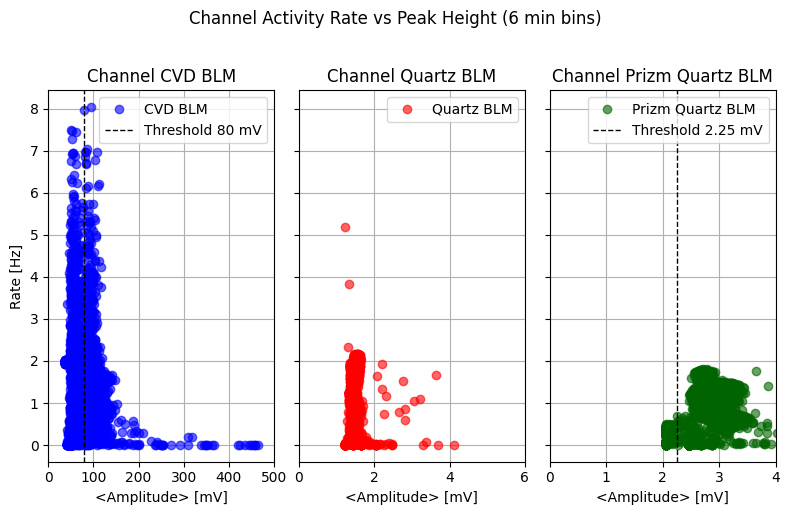

In [539]:
channels = combined['ch'].unique()
# Plotting the rate per second for each channel
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 5), sharey=True)
xlim = {1:500, 2:6, 3:4}  # Set x-axis limits for each channel
for i, ch in enumerate(sorted(channels)):
    df_ch = combined[(combined['ch'] == ch) & (combined['rate_per_sec'] > 0)]
    axs[i].plot(1000*df_ch['avg_peak_height'], df_ch['rate_per_sec'],
                label=ch_label[ch],
                marker='o', linestyle='', color=blm_col[ch], alpha=0.6)

    axs[i].set_xlabel('<Amplitude> [mV]')    
    axs[i].set_title(f'Channel {ch_label[ch]}')
    #axs[i].set_xscale('log')
    axs[i].set_xlim(0, xlim[ch])  # Set x-axis limit to 0-1000 mV
    axs[i].grid(True)
    #axs[i].legend()

axs[0].set_ylabel('Rate [Hz]')
# Draw vertical line at 80 mV on the first axis (axs[0])
axs[0].axvline(x=80, color='black', linestyle='--', linewidth=1, label='Threshold 80 mV')
axs[0].legend()
axs[1].legend()

# Draw vertical line at 2.25 on the last axis (axs[-1])
axs[-1].axvline(x=2.25, color='black', linestyle='--', linewidth=1, label='Threshold 2.25 mV')
axs[-1].legend()

plt.suptitle(f'Channel Activity Rate vs Peak Height ({avg_min} min bins)', y=1.02)
plt.tight_layout()
plt.savefig(f"./Plots/peak_heights_vs_rate_by_channel_{date_string}.png", dpi=300)
plt.show()

CVD diamond based BLM is showing high rate at low amplitudes some times, maybe it is related to collision background. Thus, we will implement lower threshold for CVD BLM at 80 mV and 2.25 mv for Quartz BLM. There is a structure in the rate, not clear what tis the source yet

In [540]:
df = df[
    ((df['peak_heights'] > 0.085) & (df['ch'] == 1)) |
    ((df['peak_heights'] > 0.00225) & (df['ch'] == 3)) |
    ((df['peak_heights'] > 0.0012) & (df['ch'] == 2))
]

Rate versus time:

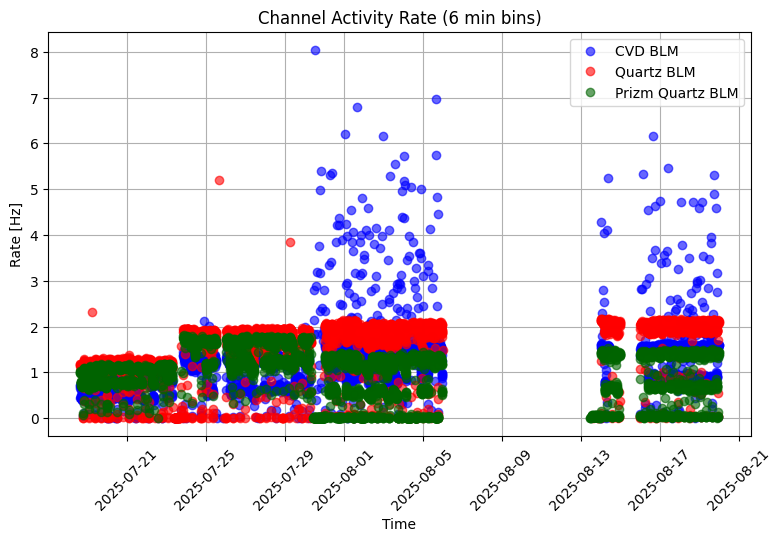

In [541]:
plt.figure(figsize=(8, 5))
for ch in combined['ch'].unique():
    if ch==1:
        df_ch = combined[(counts['ch'] == ch) & (combined['rate_per_sec'] > 0) & (combined['avg_peak_height'] > 0.085)]
    if ch==2:
        df_ch = combined[(counts['ch'] == ch) & (combined['rate_per_sec'] > 0) & (combined['avg_peak_height'] > 0.0012)]
    if ch==3:
        df_ch = combined[(counts['ch'] == ch) & (combined['rate_per_sec'] > 0) & (combined['avg_peak_height'] > 0.00225)]
    plt.plot(df_ch['timestamp'], df_ch['rate_per_sec'], label=ch_label[ch], marker='o', linestyle='', color=blm_col[ch],  alpha=0.6)

plt.xlabel('Time')
plt.ylabel('Rate [Hz]')
plt.title(f'Channel Activity Rate ({avg_min} min bins)')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.savefig(f"./Plots/rate_vs_time_{date_string}.png", dpi=300)

plt.show()

Peak Height with respect to the beam revolution trigger:

/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_35427/3920132058.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_35427/3920132058.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"./Plots/amp_vs_revsig_{date_string}.png", dpi=300)
/Users/evgenyshulga/Work/EIC/BLM/rhic_blm_daq/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


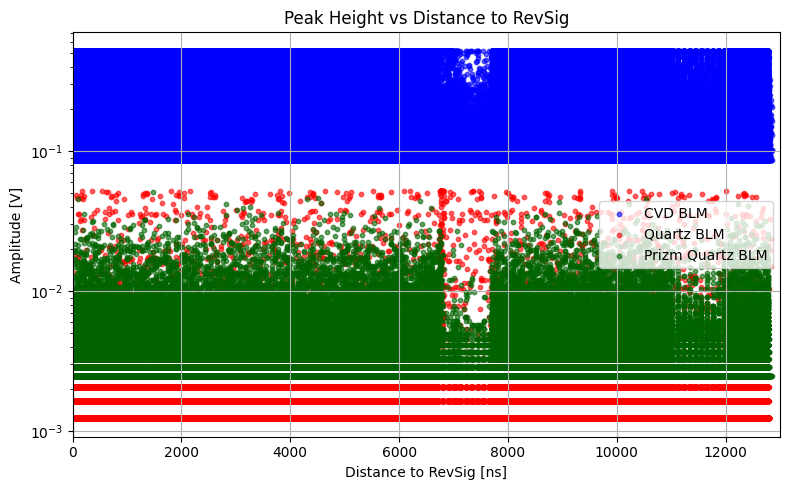

In [542]:
# Plot
plt.figure(figsize=(8, 5))
for ch in combined['ch'].unique():        
    plt.scatter(df[df['ch']==ch]['dist_to_revsig_ns'], df[df['ch']==ch]['peak_heights'], color=blm_col[ch], label=ch_label[ch], s=10, alpha=0.6)
plt.xlabel('Distance to RevSig [ns]')
plt.ylabel('Amplitude [V]')
plt.title('Peak Height vs Distance to RevSig')
plt.grid(True)
plt.xlim(-1, 13000)
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.savefig(f"./Plots/amp_vs_revsig_{date_string}.png", dpi=300)

plt.show()


Amplitude versus time:

/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_35427/2929095602.py:11: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_35427/2929095602.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"./Plots/amp_vs_time_{date_string}.png", dpi=300)


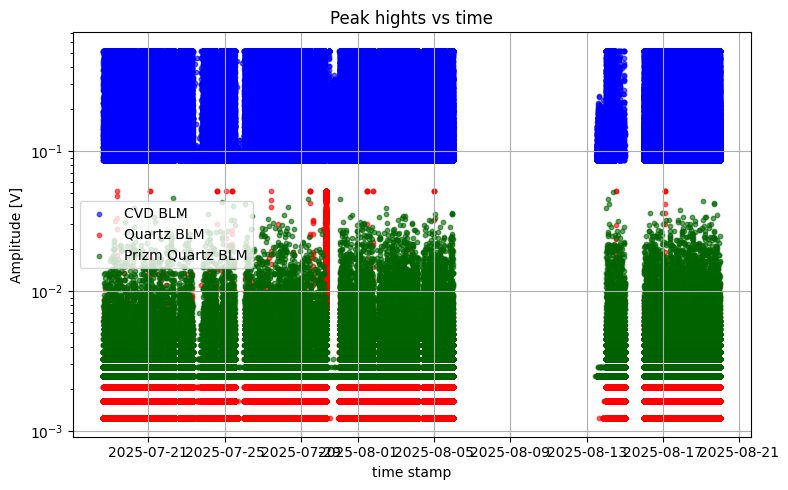

In [543]:
plt.figure(figsize=(8, 5))
for ch in combined['ch'].unique():        
    plt.scatter(df[df['ch']==ch]['timestamp'], df[df['ch']==ch]['peak_heights'], color=blm_col[ch], label=ch_label[ch], s=10, alpha=0.6)
plt.xlabel('time stamp')
plt.ylabel('Amplitude [V]')
plt.title('Peak hights vs time')
plt.grid(True)
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.savefig(f"./Plots/amp_vs_time_{date_string}.png", dpi=300)

plt.show()


In [544]:
# Ensure Timestamp is datetime and set index
df_current['Timestamp'] = pd.to_datetime(df_current['Timestamp'])
df_current = df_current.set_index('Timestamp')

current = df_current['bluDCCTtotal']
intervals = []

i = 0
while i < len(current) - 1:
    # Find first drop below or equal to 200 from above
    if current.iloc[i] > 210 and current.iloc[i + 1] <= 210:
        drop_200_time = current.index[i + 1]

        # Now look forward for drop below or equal to 50
        j = i + 1
        while j < len(current) and current.iloc[j] > 50:
            j += 1
        if j < len(current):
            drop_50_time = current.index[j]
            intervals.append(
                (drop_200_time,
                drop_50_time)
            )
            i = j  # skip ahead to after this drop
        else:
            break
    else:
        i += 1


To exclude contribution from unstable beam, selecting certain intensity intervals: 50<Intensity<210

/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_35427/2475288527.py:25: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_35427/2475288527.py:26: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"./Plots/stable_beam_intervals_{use_dates}_ramp_abort.png", dpi=300)
/Users/evgenyshulga/Work/EIC/BLM/rhic_blm_daq/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


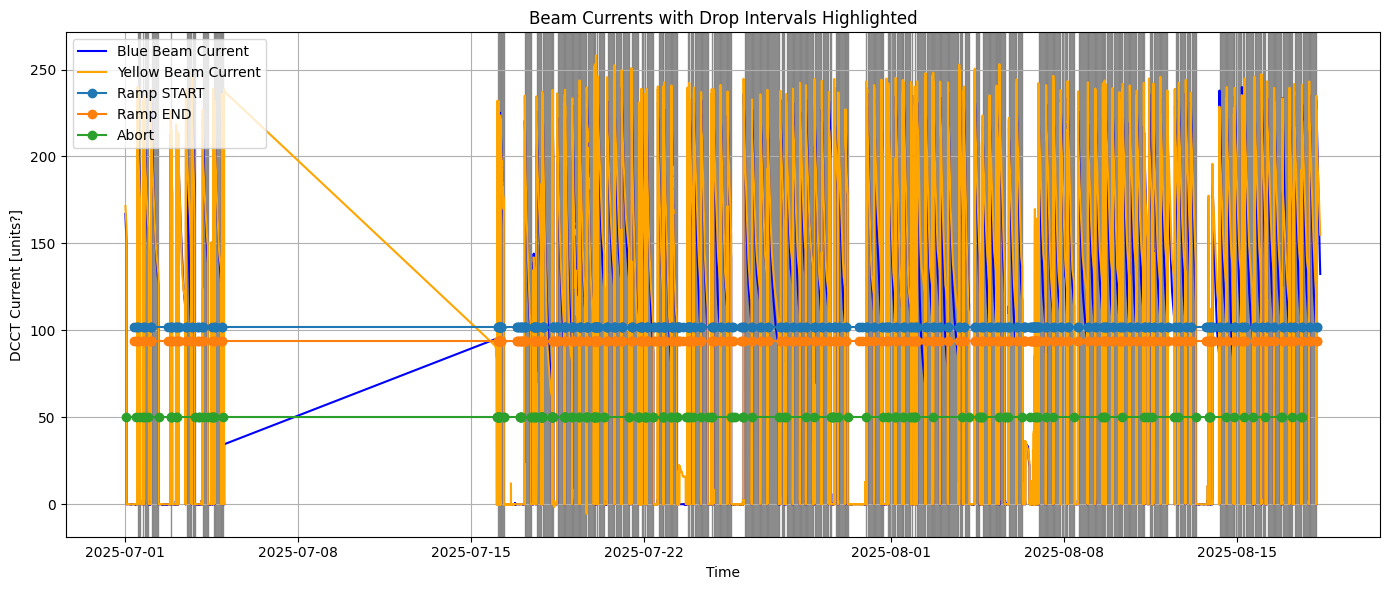

In [545]:
# Plotting
plt.figure(figsize=(14, 6))
plt.plot(df_current.index, df_current['bluDCCTtotal'], label='Blue Beam Current', color='blue')
plt.plot(df_current.index, df_current['yelDCCTtotal'], label='Yellow Beam Current', color='orange')
plt.plot(df_start['Timestamp'], df_start['StartRamp'], label='Ramp START', marker='o', linestyle='-')
plt.plot(df_end['Timestamp'], df_end['StopRamp'], label='Ramp END', marker='o', linestyle='-')
plt.plot(df_abort['Timestamp'], df_abort['Abort'], label='Abort', marker='o', linestyle='-')
for start, end in intervals:#overlapping_intervals:
    plt.axvspan(start, end, color='gray', alpha=0.9)

# Convert list of dicts to DataFrame
intervals_df = pd.DataFrame(intervals,columns=['start','end'])

# Save to CSV
intervals_df.to_csv(f'stable_beam_intervals_{use_dates}.csv', index=False)

plt.xlabel("Time")
plt.ylabel("DCCT Current [units?]")
plt.title("Beam Currents with Drop Intervals Highlighted")
#plt.ylim(1e-2, 300)

#plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"./Plots/stable_beam_intervals_{use_dates}_ramp_abort.png", dpi=300)

plt.show()

/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_35427/3824926023.py:33: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_35427/3824926023.py:34: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"./Plots/stable_beam_intervals_{use_dates}_ramp_abort_zoom.png", dpi=300)


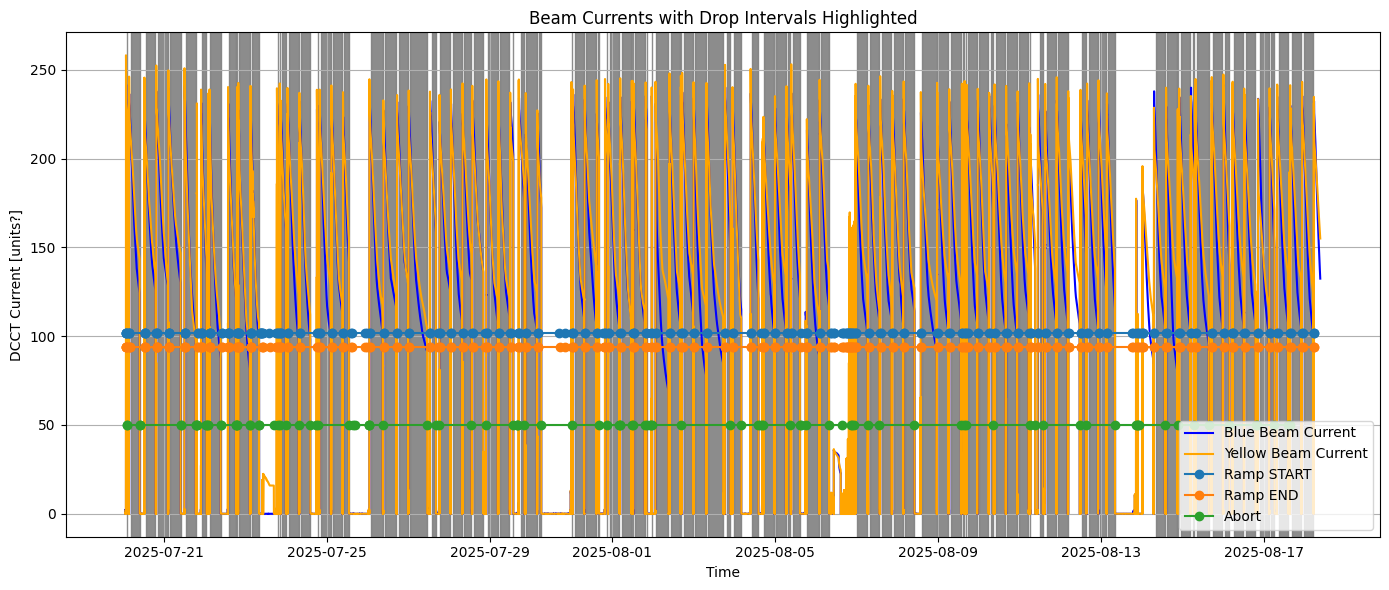

In [546]:
start_time = pd.to_datetime("2025-07-20 01:00:00")
end_time = pd.to_datetime("2025-08-20 14:00:00")
# Plotting
plt.figure(figsize=(14, 6))
selection_1 = ((df_current.index >= start_time) & (df_current.index <= end_time))
selection_start = ((df_start['Timestamp'] >= start_time) & (df_start['Timestamp'] <= end_time))
selection_end = ((df_end['Timestamp'] >= start_time) & (df_end['Timestamp'] <= end_time))
selection_abort = ((df_abort['Timestamp'] >= start_time) & (df_abort['Timestamp'] <= end_time))

plt.plot(df_current[selection_1].index, df_current[selection_1]['bluDCCTtotal'], label='Blue Beam Current', color='blue')
plt.plot(df_current[selection_1].index, df_current[selection_1]['yelDCCTtotal'], label='Yellow Beam Current', color='orange')
plt.plot(df_start[selection_start]['Timestamp'], df_start[selection_start]['StartRamp'], label='Ramp START', marker='o', linestyle='-')
plt.plot(df_end[selection_end]['Timestamp'], df_end[selection_end]['StopRamp'], label='Ramp END', marker='o', linestyle='-')
plt.plot(df_abort[selection_abort]['Timestamp'], df_abort[selection_abort]['Abort'], label='Abort', marker='o', linestyle='-')
for start, end in intervals:#overlapping_intervals:
    if start >= start_time and end <= end_time:
        plt.axvspan(start, end, color='gray', alpha=0.9)

## Convert list of dicts to DataFrame
#intervals_df = pd.DataFrame(intervals,columns=['start','end'])
#
## Save to CSV
#intervals_df.to_csv(f'stable_beam_intervals_{use_dates}.csv', index=False)

plt.xlabel("Time")
plt.ylabel("DCCT Current [units?]")
plt.title("Beam Currents with Drop Intervals Highlighted")
#plt.ylim(1e-2, 300)

#plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"./Plots/stable_beam_intervals_{use_dates}_ramp_abort_zoom.png", dpi=300)

plt.show()

Using only stable beam conditions:

In [547]:
# Load your main data (assuming it's already in variable df)
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Load the intervals CSV
intervals = pd.read_csv(f'./stable_beam_intervals_{use_dates}.csv')
intervals['start'] = pd.to_datetime(intervals['start'])
intervals['end'] = pd.to_datetime(intervals['end'])
intervals['start_plus_30min'] = intervals['start'] + pd.Timedelta(minutes=30)
# Create a mask to keep only rows in df within any interval
mask = pd.Series(False, index=df.index)
mask_combined = pd.Series(False, index=combined.index)

for _, row in intervals.iterrows():
    mask |= (df['timestamp'] >= row['start']) & (df['timestamp'] <= row['end'])
    mask_combined |= (combined['timestamp'] >= row['start']) & (combined['timestamp'] <= row['end'])
    #mask |= (df['timestamp'] >= row['start']) & (df['timestamp'] <= row['start_plus_30min'])

# Filtered DataFrame
df = df[mask].copy()

#print(df_filtered)

# Flatten the dist_to_revsig values (assumes each cell is a list)
all_distances_1_filtered = df[(df['ch']==1 ) & ( df['dist_to_revsig']<=0)]['dist_to_revsig_ns'].explode().astype(float)
all_distances_2_filtered = df[(df['ch']==2 ) & ( df['dist_to_revsig']<=0)]['dist_to_revsig_ns'].explode().astype(float)
all_distances_3_filtered = df[(df['ch']==3 ) & ( df['dist_to_revsig']<=0)]['dist_to_revsig_ns'].explode().astype(float)


/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_35427/223831059.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_35427/223831059.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig(f"./Plots/amp_vs_time_{date_string}.png", dpi=300)
/Users/evgenyshulga/Work/EIC/BLM/rhic_blm_daq/.venv/lib/python3.13/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


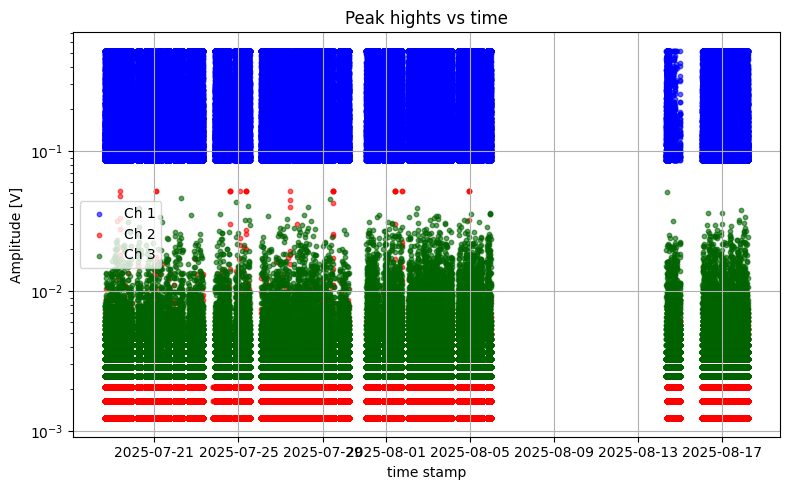

In [548]:
plt.figure(figsize=(8, 5))
        
plt.scatter(df[df['ch']==1]['timestamp'], df[df['ch']==1]['peak_heights'], color='blue', label=f"Ch 1", s=10, alpha=0.6)
plt.scatter(df[df['ch']==2]['timestamp'], df[df['ch']==2]['peak_heights'], color='red', label=f"Ch 2", s=10, alpha=0.6)
plt.scatter(df[df['ch']==3]['timestamp'], df[df['ch']==3]['peak_heights'], color='darkgreen', label=f"Ch 3", s=10, alpha=0.6)
plt.xlabel('time stamp')
plt.ylabel('Amplitude [V]')
plt.title('Peak hights vs time')
plt.grid(True)
plt.yscale('log')
plt.legend()

plt.tight_layout()
plt.savefig(f"./Plots/amp_vs_time_{date_string}.png", dpi=300)

plt.show()

Amplitude distribution:

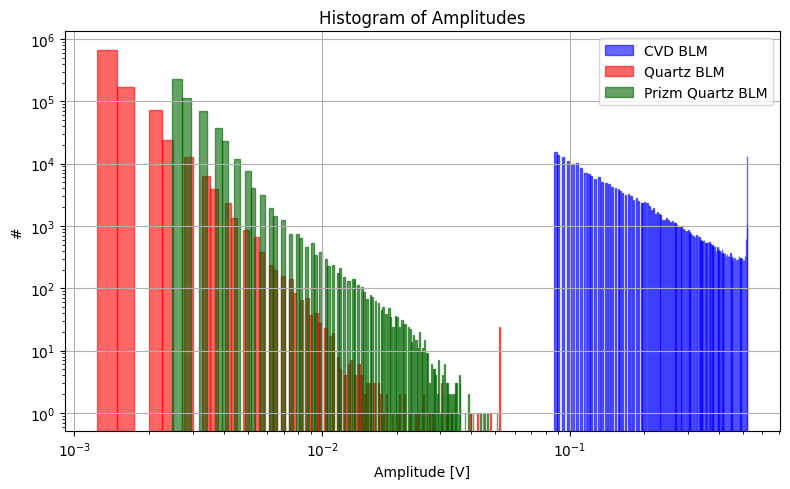

In [549]:
# Plot histogram
plt.figure(figsize=(8, 5))
for ch in combined['ch'].unique():        
    plt.hist(df[df['ch']==ch]['peak_heights'], bins=200, color=blm_col[ch], edgecolor=blm_col[ch], label=ch_label[ch], alpha=0.6)

plt.xlabel('Amplitude [V]')
plt.ylabel('#')
plt.title('Histogram of Amplitudes')
plt.grid(True)
plt.xscale('log')
plt.yscale('log')

plt.legend()

plt.tight_layout()
plt.savefig(f"./Plots/amp_{date_string}.png", dpi=300)
plt.show()

To show time from beam revolution trigger to signal in the detector need to extract all distances

In [550]:
# Flatten the dist_to_revsig values (assumes each cell is a list)
all_distances_1 = df[(df['ch']==1 ) & ( df['dist_to_revsig']<=0)]['dist_to_revsig_ns'].explode().astype(float)
all_distances_2 = df[(df['ch']==2 ) & ( df['dist_to_revsig']<=0)]['dist_to_revsig_ns'].explode().astype(float)
all_distances_3 = df[(df['ch']==3 ) & ( df['dist_to_revsig']<=0)]['dist_to_revsig_ns'].explode().astype(float)


Plot the timing:

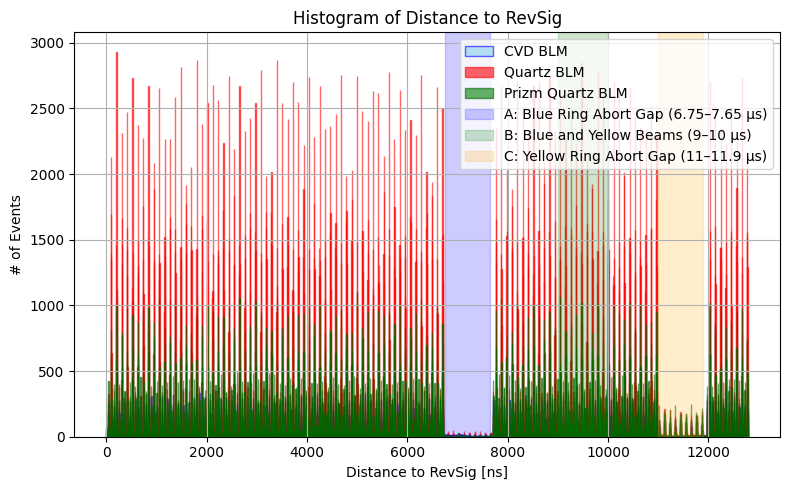

In [551]:
# Plot histogram
plt.figure(figsize=(8,5))
plt.hist(all_distances_1, bins=4000, color='skyblue', edgecolor=blm_col[1], label=ch_label[1], alpha=0.6)
plt.hist(all_distances_2, bins=4000, color='red'    , edgecolor=blm_col[2], label=ch_label[2], alpha=0.6)
plt.hist(all_distances_3, bins=4000, color='green'  , edgecolor=blm_col[3], label=ch_label[3], alpha=0.6)
# Add shaded boxes for regions A, B, C (convert us to ns)
plt.axvspan(6.75e3, 7.65e3, color='blue',    alpha=0.2, label='A: Blue Ring Abort Gap (6.75–7.65 µs)')
plt.axvspan(9e3, 10e3,     color='green',   alpha=0.2,  label='B: Blue and Yellow Beams (9–10 µs)')
plt.axvspan(11e3, 11.9e3,   color='orange',  alpha=0.2, label='C: Yellow Ring Abort Gap (11–11.9 µs)')

plt.xlabel('Distance to RevSig [ns]')
plt.ylabel('# of Events')
plt.title('Histogram of Distance to RevSig')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.savefig(f"./Plots/revsig_{date_string}.png", dpi=300)

plt.show()

Zoom in:
- A: 6.75 to 7.6
5 microseconds

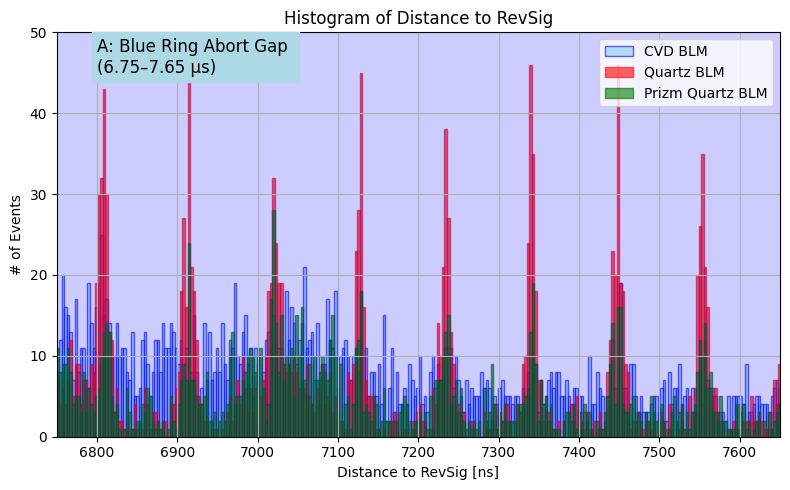

In [552]:
# Plot histogram
fig, ax = plt.subplots(figsize=(8, 5))

# Plot histogram as usual
ax.hist(all_distances_1, bins=4000, color='skyblue', edgecolor=blm_col[1], label=ch_label[1], alpha=0.6)
ax.hist(all_distances_2, bins=4000, color='red', edgecolor=blm_col[2], label=ch_label[2], alpha=0.6)
ax.hist(all_distances_3, bins=4000, color='green', edgecolor=blm_col[3], label=ch_label[3], alpha=0.6)

ax.set_xlim(6750, 7650)
ax.set_ylim(0, 50)
ax.set_xlabel('Distance to RevSig [ns]')
ax.set_ylabel('# of Events')
ax.set_title('Histogram of Distance to RevSig')
# Add the green box
rect = patches.Rectangle((6750, 0), 1000, ax.get_ylim()[1], linewidth=0, facecolor='blue', alpha=0.2)
ax.add_patch(rect)

# Add the label inside the green box
ax.text(6800, ax.get_ylim()[1]*0.9, 'A: Blue Ring Abort Gap \n(6.75–7.65 µs)',
        fontsize=local_fontsize, color='black', backgroundcolor='lightblue')

ax.grid(True)
ax.legend()

plt.tight_layout()
plt.savefig(f"./Plots/revsig_{date_string}_A.png", dpi=300)

plt.show()


- B: 10 to 11 microseconds

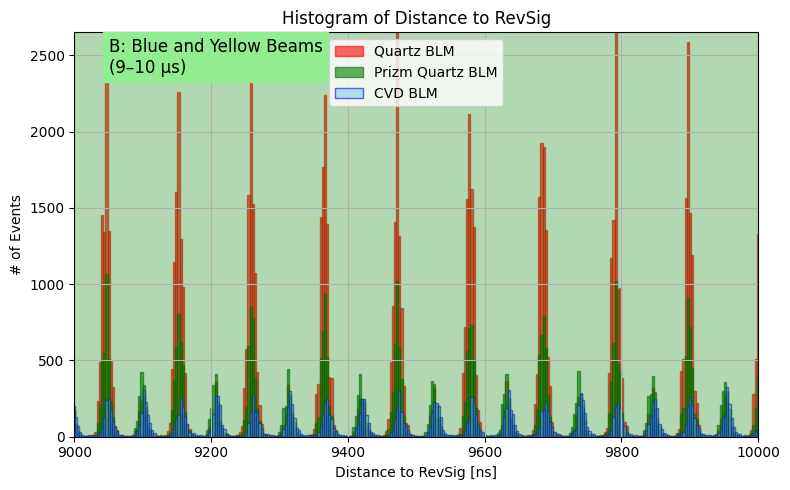

In [553]:
# Plot histogram
fig, ax = plt.subplots(figsize=(8, 5))


# Plot histogram as usual
ax.hist(all_distances_2, bins=4000, color='red', edgecolor=blm_col[2], label=ch_label[2], alpha=0.6)
ax.hist(all_distances_3, bins=4000, color='green', edgecolor=blm_col[3], label=ch_label[3], alpha=0.6)
ax.hist(all_distances_1, bins=4000, color='skyblue', edgecolor=blm_col[1], label=ch_label[1], alpha=0.6)

ax.set_xlim(9000, 10000)
ax.set_ylim(0, 2650)

ax.set_xlabel('Distance to RevSig [ns]')
ax.set_ylabel('# of Events')
ax.set_title('Histogram of Distance to RevSig')
# Add the green box
rect = patches.Rectangle((9000, 0), 1000, ax.get_ylim()[1], linewidth=0, facecolor='green', alpha=0.3)
ax.add_patch(rect)

# Add the label inside the green box
ax.text(9050, ax.get_ylim()[1]*0.9, 'B: Blue and Yellow Beams\n(9–10 µs)',
        fontsize=local_fontsize, color='black', backgroundcolor='lightgreen')

ax.grid(True)
ax.legend()

plt.tight_layout()
plt.savefig(f"./Plots/revsig_{date_string}_B.png", dpi=300)

plt.show()

- C: 11 to 11.9 microseconds

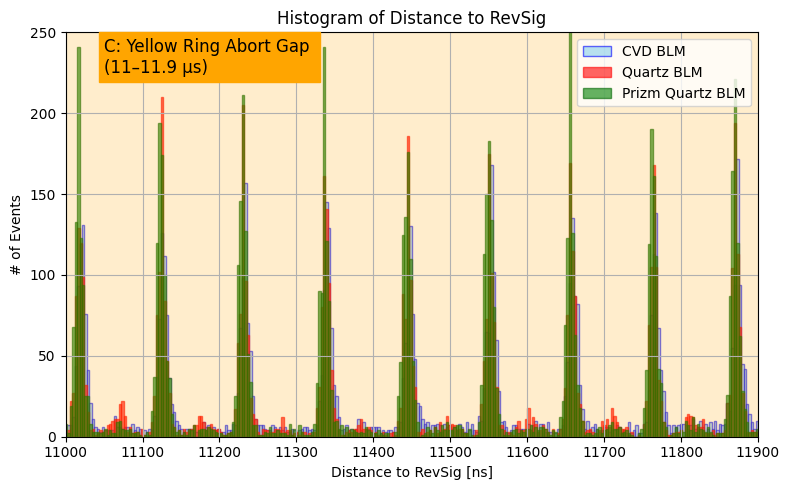

In [554]:
# Plot histogram
fig, ax = plt.subplots(figsize=(8, 5))

# Plot histogram as usual
ax.hist(all_distances_1, bins=4000, color='skyblue', edgecolor=blm_col[1], label=ch_label[1], alpha=0.6)
ax.hist(all_distances_2, bins=4000, color='red', edgecolor=blm_col[2], label=ch_label[2], alpha=0.6)
ax.hist(all_distances_3, bins=4000, color='green', edgecolor=blm_col[3], label=ch_label[3], alpha=0.6)

ax.set_xlim(11e3, 11.9e3)
ax.set_ylim(0, 250)
ax.set_xlabel('Distance to RevSig [ns]')
ax.set_ylabel('# of Events')
ax.set_title('Histogram of Distance to RevSig')
# Add the green box
rect = patches.Rectangle((11e3, 0), 1000, ax.get_ylim()[1], linewidth=0, facecolor='orange', alpha=0.2)
ax.add_patch(rect)

# Add the label inside the green box
ax.text(11050, ax.get_ylim()[1]*0.9, 'C: Yellow Ring Abort Gap \n(11–11.9 µs)',
        fontsize=local_fontsize, color='black', backgroundcolor='orange')

ax.grid(True)
ax.legend()

plt.tight_layout()
plt.savefig(f"./Plots/revsig_{date_string}_C.png", dpi=300)

plt.show()



At STAR IR the detectors see two abort gaps, one for blue and one for yellow beam. The Bunch spacing should be ~106 ns, we see signals from bunches every 106 ns. In addition we see signal every 50 ns, which do not correspond to Beam revolution trigger jitter or detector effects as we use 4 separate detector systems and 2 different readouts.

In [555]:
avg_min = 6 #data taking is N min each, should be >6 minutes
# Count occurrences per N minutes for each channel
counts = df.groupby([
    pd.Grouper(key='timestamp', freq=f'{avg_min}min'),  # round timestamps to avg_min bins
    'ch'
]).size().reset_index(name='count')
# Group and compute mean peak_heights
avg_heights = df.groupby([
    pd.Grouper(key='timestamp', freq=f'{avg_min}min'),
    'ch'
])['peak_heights'].mean().reset_index(name='avg_peak_height')

# Merge rate and average height by time + channel
combined = pd.merge(counts, avg_heights, on=['timestamp', 'ch'], how='left')

# Optional: calculate rate per minute (divide by avg_min)
counts['rate_per_min'] = counts['count'] / (avg_min/3)
counts['rate_per_sec'] = counts['count'] / (avg_min/3*60)
# Optional: calculate rate per minute (divide by avg_min)
combined['rate_per_min'] = combined['count'] / (avg_min/3)
combined['rate_per_sec'] = combined['count'] / (avg_min/3*60)

In [556]:
# Ensure Timestamp is datetime and set index
#df_current['Timestamp'] = pd.to_datetime(df_current['Timestamp'])
#df_current = df_current.set_index('Timestamp')

current = df_current['bluDCCTtotal']
intervals = []

i = 0
while i < len(current) - 1:
    # Find first drop below or equal to 200 from above
    if current.iloc[i] > 210 and current.iloc[i + 1] <= 210:
        drop_200_time = current.index[i + 1]

        # Now look forward for drop below or equal to 50
        j = i + 1
        while j < len(current) and current.iloc[j] > 50:
            j += 1
        if j < len(current):
            drop_50_time = current.index[j]
            intervals.append(
                (drop_200_time,
                drop_50_time)
            )
            i = j  # skip ahead to after this drop
        else:
            break
    else:
        i += 1


ValueError: too many values to unpack (expected 2)

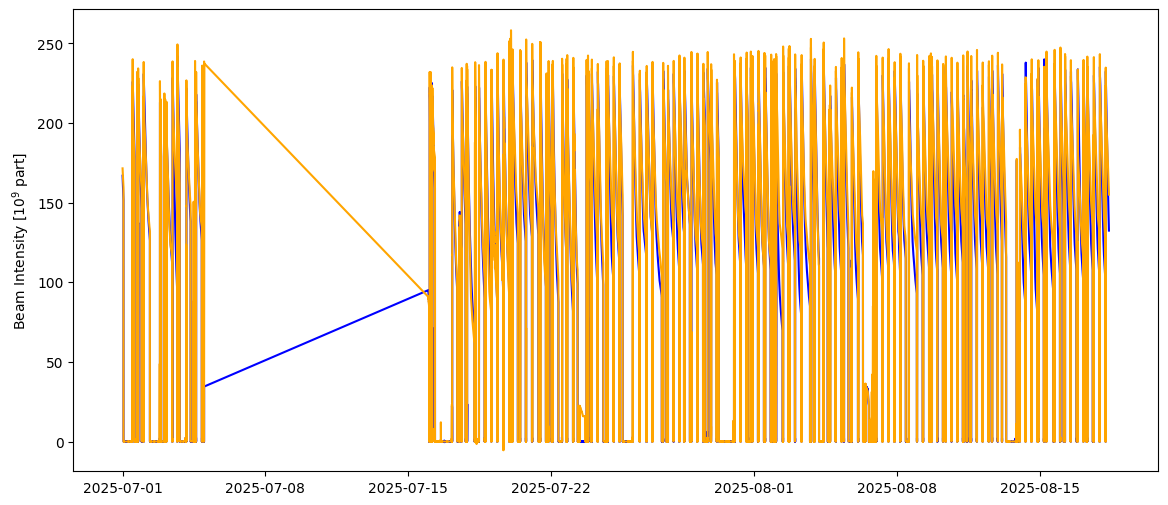

In [534]:
fig, ax1 = plt.subplots(figsize=(14, 6))
start_time = pd.to_datetime("2025-07-20 14:00:00")
end_time = pd.to_datetime("2025-08-18 01:00:00")

# Left Y-axis (ax1) — Beam Current
ax1.plot(df_current.index, df_current['bluDCCTtotal'], label='Blue Beam', color='blue')
ax1.plot(df_current.index, df_current['yelDCCTtotal'], label='Yellow Beam', color='orange')
ax1.set_ylabel(f'Beam Intensity [$10^{9}$ part]', color='black')

# Highlight intervals on ax1
for start, end in intervals:
    ax1.axvspan(start, end, color='gray', alpha=0.9)

# Right Y-axis (ax2) — Rate per sec
ax2 = ax1.twinx()

for ch in combined['ch'].unique():
    df_ch = combined[(combined['ch'] == ch) & (combined['rate_per_sec'] > 0)]
    ax2.plot(df_ch['timestamp'], df_ch['rate_per_sec'],
            label=ch_label[ch], marker='o', linestyle='', color=blm_col[ch], alpha=0.6)

ax2.set_ylabel('BLM Rate [Hz]', color='black')

# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

ax1.set_xlim(start_time, end_time)
ax2.set_xlim(start_time, end_time)
# X-axis and Title
ax1.set_xlabel("Time")
plt.title("Beam Intensity and BLM Rates with Drop Intervals Highlighted")
ax1.grid(True)

plt.tight_layout()
plt.savefig(f"./Plots/stable_beam_intervals_{use_dates}.png", dpi=300)
plt.show()


            timestamp  ch  count  avg_peak_height  rate_per_min  rate_per_sec
0 2025-07-18 15:18:00   1     22         0.204639          11.0      0.183333
1 2025-07-18 15:24:00   1     54         0.201189          27.0      0.450000
2 2025-07-18 15:24:00   2    206         0.001378         103.0      1.716667
3 2025-07-18 15:24:00   3    120         0.002960          60.0      1.000000
4 2025-07-18 15:30:00   1     35         0.201646          17.5      0.291667


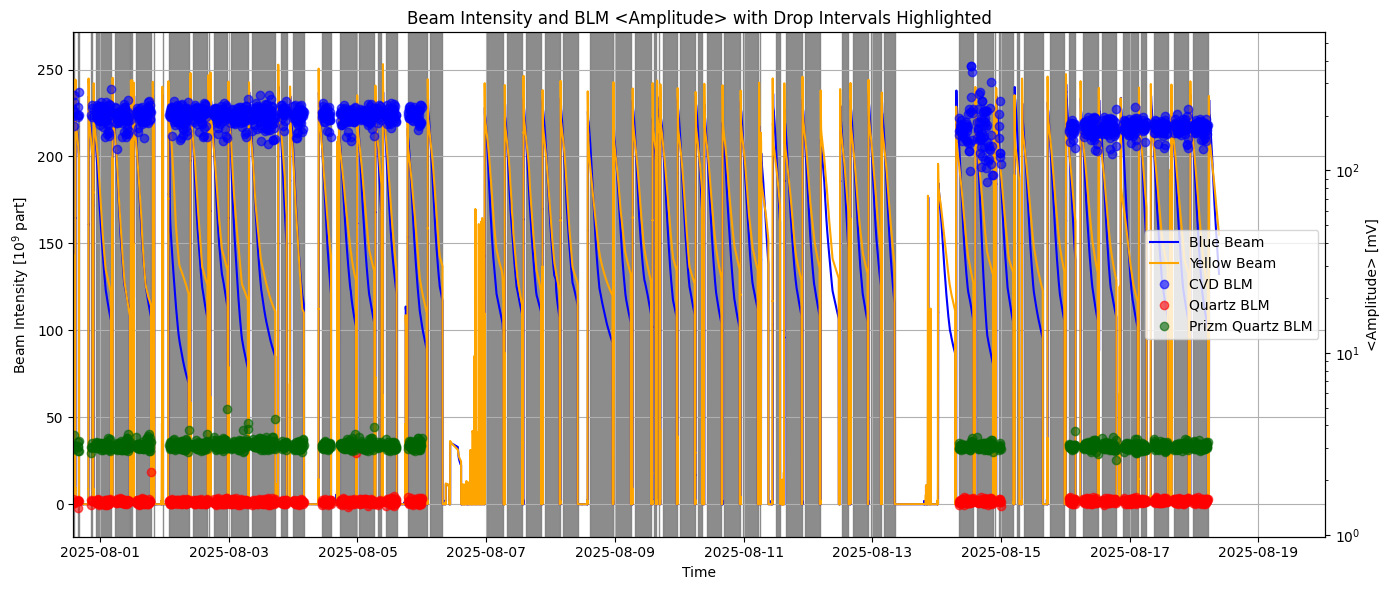

In [354]:
print(combined.head())
fig, ax1 = plt.subplots(figsize=(14, 6))
start_time = pd.to_datetime("2025-07-31 14:00:00")
end_time = pd.to_datetime("2025-08-20 01:00:00")

# Left Y-axis (ax1) — Beam Current
ax1.plot(df_current.index, df_current['bluDCCTtotal'], label='Blue Beam', color='blue')
ax1.plot(df_current.index, df_current['yelDCCTtotal'], label='Yellow Beam', color='orange')
ax1.set_ylabel(f'Beam Intensity [$10^{9}$ part]', color='black')

# Highlight intervals on ax1
for start, end in intervals:
    ax1.axvspan(start, end, color='gray', alpha=0.9)

# Right Y-axis (ax2) — Rate per sec
ax2 = ax1.twinx()

for ch in combined['ch'].unique():
    df_ch = combined[(combined['ch'] == ch) & (combined['avg_peak_height'] > 0)]
    ax2.plot(df_ch['timestamp'], 1000*df_ch['avg_peak_height'],
             label=ch_label[ch], marker='o', linestyle='', color=blm_col[ch], alpha=0.6)

ax2.set_ylabel('<Amplitude> [mV]', color='black')
# Combine legends from both axes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='center right')

ax1.set_xlim(start_time, end_time)
ax2.set_xlim(start_time, end_time)

ax2.set_yscale('log')

# X-axis and Title
ax1.set_xlabel("Time")
plt.title("Beam Intensity and BLM <Amplitude> with Drop Intervals Highlighted")
ax1.grid(True)

plt.tight_layout()
plt.savefig(f"./Plots/stable_beam_intervals_amp_{use_dates}.png", dpi=300)
plt.show()


In [355]:
import matplotlib.patches as patches
from pathlib import Path


# %% List of data dirs
dir_list = [
    ## CH_A: CLAWS BOT, CH_B: CLAWS TOP, CH_C: Trig.
#    "../data/CLAWS_RHIC_DATA/20250716_143917623526", 
#    "../data/CLAWS_RHIC_DATA/20250721_092744756441",
#    "../data/CLAWS_RHIC_DATA/20250724_102719259226",
    ## CH_A: CLAWS BOT, CH_B: CLAWS TOP, CH_C: Trig., CH_D: Fiber (1.0sec)
#    "../data/CLAWS_RHIC_DATA/20250725_174720941787",
#    "../data/CLAWS_RHIC_DATA/20250728_091722576696",
    ## CH_A: CLAWS BOT, CH_B: CLAWS TOP (rot), CH_C: Trig., CH_D: Fiber (0.1sec)
#    "../data/CLAWS_RHIC_DATA/20250730_102401148202",
    ## CH_A: CLAWS BOT, CH_B: CLAWS TOP (rot), CH_C: Trig., CH_D: sCDV+EOM
    #"../CLAWS_RHIC_DATA/20250801_173948393272",
    #"../CLAWS_RHIC_DATA/20250804_090710098321",
    #"../CLAWS_RHIC_DATA/20250805_100032892545",
    #"../CLAWS_RHIC_DATA/20250808_113636405414",
    #"../CLAWS_RHIC_DATA/20250808_154206324633",
    #"../CLAWS_RHIC_DATA/20250811_133120109216",
    "../CLAWS_RHIC_DATA/20250813_142039864608",
    ## Changed the output power + lowered threshold
#    "../data/CLAWS_RHIC_DATA/20250815_093622124864",
#    "../data/CLAWS_RHIC_DATA/20250815_114718553559",
    ## Changed the output power + lowered threshold
#    "../CLAWS_RHIC_DATA/20250818_091416584871",
]
#------------- RHIC RF setup
RF_freq_Hz = 28.15e6 # [Hz] https://journals.aps.org/prab/pdf/10.1103/PhysRevAccelBeams.22.102001
RF_h = 360 # harmonic number - number of buckets
fill_pattern = 120 # = RF_h/3 - number of bunches (including abort gap)
tRev_ns = 1./RF_freq_Hz * RF_h * 1e9 # [ns] revolution time
print(f"[INFO] RHIC revolution time = {tRev_ns:.1f} ns")

#------------- Picoscope setup
dtime_ns = 4.0 # picoscope time resolution [ns/sample]
sig_a_offset_V = -0.08  # [V] - voltage offset for the channel CH_A
sig_a_range_V = 100e-3  # [V] - voltage range for channel CH_A
sig_b_offset_V = -0.08  # [V] - voltage offset for the channel CH_B
sig_b_range_V = 100e-3  # [V] - voltage range for channel CH_B
sig_c_offset_V = 0      # [V] - voltage offset for the channel CH_C
sig_c_range_V = 5       # [V] - voltage range for the channel CH_C

# Jul25-Aug1
#sig_d_offset_V = 0      # [V] - voltage offset for the channel CH_D
#sig_d_range_V = 5       # [V] - voltage range for the channel CH_D

# Aug1-
sig_d_offset_V = -0.08  # [V] - voltage offset for the channel CH_D
sig_d_range_V = 100e-3  # [V] - voltage range for the channel CH_D

nbits = 16 # 2^16 - voltage reoslution
buffer_size = 134217664 # see the config file

print(f"[INFO] buffer_size = {buffer_size} samples x {dtime_ns} ns/sample -> {buffer_size * dtime_ns * 1e-6:.3f} [ms]")

# Get State Store
def is_in_store(timestamp_datetime64):
    pos = df_store_state['Timestamp'].astype('datetime64[ns]').to_numpy().searchsorted(timestamp_datetime64)
    # If pos == 0: the timestamp is before the first record → return 0
    # If pos == len(df): it's after the last record → return 0
    # Otherwise: interpolate between pos-1 and pos
    is_in_store = 0
    if (pos != 0) & (pos != len(df_store_state)):
        # Get the average over 4 neighbor points
        interpolated = (
            df_store_state.loc[pos - 1, 'StoreState'] +
            df_store_state.loc[pos, 'StoreState'])/2.
        is_in_store = int(interpolated >= 0.5)
    return is_in_store

[INFO] RHIC revolution time = 12788.6 ns
[INFO] buffer_size = 134217664 samples x 4.0 ns/sample -> 536.871 [ms]


In [356]:
# %% Get pre-ana data
# Folder with CLAWS .pqt files
files_a = []
files_b = []
files_d = []
for dir_name in dir_list:
    data_dir = Path(dir_name)
    files_a.append(sorted(data_dir.glob("*_a.pqt")))
    files_b.append(sorted(data_dir.glob("*_b.pqt")))
    files_d.append(sorted(data_dir.glob("*_d.pqt")))

files_a = np.concatenate(files_a)
files_b = np.concatenate(files_b)
files_d = np.concatenate(files_d)

# Initialize accumulator
nbins = int(tRev_ns / dtime_ns) # number of bins
bin_range = (0, tRev_ns) # bin range - one revolution
accum_counts_a = np.zeros(nbins) # counts per bin
accum_counts_b = np.zeros(nbins)
accum_counts_d = np.zeros(nbins)
accum_counts_a_store = np.zeros(nbins) # counts per bin
accum_counts_b_store = np.zeros(nbins)
accum_counts_d_store = np.zeros(nbins)
print(f"[INFO] Accumulator nbins = {nbins}")

# Convert ADC counts into mV
def adc2mv(adc_counts,range_V,offset_V):
    return (adc_counts * (2. * range_V) / np.pow(2,nbits) - offset_V) * 1e3

# Arrays to plot data
timestamps_a = []
timestamps_b = []
timestamps_d = []
n_peaks_a = []
n_peaks_b = []
n_peaks_d = []
average_peak_heights_mV_a= []
average_peak_heights_mV_b = []
average_peak_heights_mV_d = []
average_peak_heights_above_mean_mV_a= []
average_peak_heights_above_mean_mV_b = []
average_peak_heights_above_mean_mV_d = []
median_peak_heights_above_mean_mV_a= []
median_peak_heights_above_mean_mV_b = []
median_peak_heights_above_mean_mV_d = []
mean_mV_a = []
mean_mV_b = []
mean_mV_d = []
all_peak_heights_mV_a = []
all_peak_heights_mV_b = []
all_peak_heights_mV_d = []
all_peak_width_adc_d = []
bunch_bins_ns = np.linspace(0, tRev_ns, fill_pattern+1)
print(f"[INFO] Reading {len(files_a)} + {len(files_b)} + {len(files_d)} files ...")
nReadFiles = 0

# Empty lists to collect partial dfs
list_a = []
list_b = []

# Loop over peak files
for file_a, file_b in zip(files_a,files_b):
    # Extract timestamp from filename for CH_A
    stem_a = file_a.stem  # removes .pqt
    time_part_a = stem_a.split("_a")[0]  # remove '_a' if present
    timestamp_a = datetime.strptime(time_part_a, "%Y%m%d_%H%M%S%f")
    # Extract timestamp from filename for CH_B
    stem_b = file_b.stem  # removes .pqt
    time_part_b = stem_b.split("_b")[0]  # remove '_b' if present
    timestamp_b = datetime.strptime(time_part_b, "%Y%m%d_%H%M%S%f")
    # Append timestamps
    timestamps_a.append(timestamp_a)
    timestamps_b.append(timestamp_b)
    nReadFiles = nReadFiles + 2

    # Read value from file
    df_a = pd.read_parquet(file_a, engine="fastparquet")
    df_b = pd.read_parquet(file_b, engine="fastparquet")

    list_a.append(df_a)
    list_b.append(df_b)

    # Peak time from rev tic
    dist_to_revsig_ns_a = (-1) * df_a['dist_to_revsig'] * dtime_ns
    dist_to_revsig_ns_b = (-1) * df_b['dist_to_revsig'] * dtime_ns
    # Number of peaks per buffer
    n_peaks_a.append(len(dist_to_revsig_ns_a))
    n_peaks_b.append(len(dist_to_revsig_ns_b))

    # Peak height
    peak_heights_mV_a = adc2mv(df_a['peak_heights'],sig_a_range_V,sig_a_offset_V)
    peak_heights_above_mean_mV_a = adc2mv(df_a['peak_heights_above_mean'],sig_a_range_V,0)
    average_peak_heights_mV_a.append(peak_heights_mV_a.mean())
    average_peak_heights_above_mean_mV_a.append(peak_heights_above_mean_mV_a.mean())
    median_peak_heights_above_mean_mV_a.append(peak_heights_above_mean_mV_a.median())
    all_peak_heights_mV_a.append(peak_heights_mV_a)
    mean_mV_a.append(
        (adc2mv(df_a['peak_heights'],sig_a_range_V,sig_a_offset_V) -
        adc2mv(df_a['peak_heights_above_mean'],sig_a_range_V,0)).mean()
        )
    
    peak_heights_mV_b = adc2mv(df_b['peak_heights'],sig_b_range_V,sig_b_offset_V)
    peak_heights_above_mean_mV_b = adc2mv(df_b['peak_heights_above_mean'],sig_b_range_V,0)
    average_peak_heights_mV_b.append(peak_heights_mV_b.mean())
    average_peak_heights_above_mean_mV_b.append(peak_heights_above_mean_mV_b.mean())
    median_peak_heights_above_mean_mV_b.append(peak_heights_above_mean_mV_b.median())
    all_peak_heights_mV_b.append(peak_heights_mV_b)
    mean_mV_b.append(
        (adc2mv(df_b['peak_heights'],sig_b_range_V,sig_b_offset_V) -
        adc2mv(df_b['peak_heights_above_mean'],sig_b_range_V,0)).mean()
        )

    counts_a, bin_edges_a = np.histogram(
        dist_to_revsig_ns_a, 
        bins=nbins, 
        range=bin_range
    )
    counts_b, bin_edges_b = np.histogram(
        dist_to_revsig_ns_b, 
        bins=nbins, 
        range=bin_range
    )

    # Accumulate all counts
    accum_counts_a += counts_a
    accum_counts_b += counts_b

    ## Take data only during Store
    #if is_in_store(np.datetime64(timestamp_a)): 
    #    # Accumulate counts only at store
    #    accum_counts_a_store += counts_a
    #if is_in_store(np.datetime64(timestamp_b)): 
    #    # Accumulate counts only at store
    #    accum_counts_b_store += counts_b
    
# Combine all parts into final DataFrames
df_a = pd.concat(list_a, ignore_index=True)
df_b = pd.concat(list_b, ignore_index=True)

# Loop over peak files - CH_D was usd later
for file_d in files_d:
    # Extract timestamp from filename for CH_D
    stem_d = file_d.stem  # removes .pqt
    time_part_d = stem_d.split("_d")[0]  # remove '_d' if present
    timestamp_d = datetime.strptime(time_part_d, "%Y%m%d_%H%M%S%f")
    # Append timestamps
    timestamps_d.append(timestamp_d)
    nReadFiles = nReadFiles + 1

    # Read value from file
    df_d = pd.read_parquet(file_d)
    # Set addition cut on amplitude
    #df_d = df_d[adc2mv(df_d['peak_heights_above_mean'],sig_d_range_V,0) > 13.0]
    # Set addtional cut on width
    #df_d = df_d[df_d['widths'] > 4]

    # Peak time from rev tic
    dist_to_revsig_ns_d = (-1) * df_d['dist_to_revsig'] * dtime_ns
    # Number of peaks per buffer
    n_peaks_d.append(len(dist_to_revsig_ns_d))

    # Peak height
    peak_heights_mV_d = adc2mv(df_d['peak_heights'],sig_d_range_V,sig_d_offset_V)
    peak_heights_above_mean_mV_d = adc2mv(df_d['peak_heights_above_mean'],sig_d_range_V,0)
    average_peak_heights_mV_d.append(peak_heights_mV_d.mean())
    average_peak_heights_above_mean_mV_d.append(peak_heights_above_mean_mV_d.mean())
    median_peak_heights_above_mean_mV_d.append(peak_heights_above_mean_mV_d.median())
    all_peak_heights_mV_d.append(peak_heights_mV_d)
    all_peak_width_adc_d.append(df_d['widths'])
    mean_mV_d.append(
        (adc2mv(df_d['peak_heights'],sig_d_range_V,sig_d_offset_V) -
        adc2mv(df_d['peak_heights_above_mean'],sig_d_range_V,0)).mean()
        )

    counts_d, bin_edges_d = np.histogram(
        dist_to_revsig_ns_d, 
        bins=nbins, 
        range=bin_range
    )

    # Accumulate all counts
    accum_counts_d += counts_d

    ## Take data only during Store
    #if is_in_store(np.datetime64(timestamp_d)): 
    #    # Accumulate counts only at store
    #    accum_counts_d_store += counts_d

print(f"[INFO] Read {nReadFiles} files.")

# Concatenate all arrays into one big array
if(len(files_a) > 0):
    all_peak_heights_mV_a = np.concatenate(all_peak_heights_mV_a)
    unix_time_stamps_a = [int(ts.timestamp()) for ts in timestamps_a] # UnixTimeStamp in s
    bin_centers_a = (bin_edges_a[:-1] + bin_edges_a[1:]) / 2
    print(f"[INFO] Bin size CH_A = {bin_edges_a[1]-bin_edges_a[0]:.3f} [ns]")
    #print(f"[INFO] Store/All frac. CH_A = {np.sum(accum_counts_a_store)/np.sum(accum_counts_a)}")
if(len(files_b) > 0):
    all_peak_heights_mV_b = np.concatenate(all_peak_heights_mV_b)
    unix_time_stamps_b = [int(ts.timestamp()) for ts in timestamps_b] # UnixTimeStamp in s
    bin_centers_b = (bin_edges_b[:-1] + bin_edges_b[1:]) / 2
    print(f"[INFO] Bin size CH_B = {bin_edges_b[1]-bin_edges_b[0]:.3f} [ns]")
    #print(f"[INFO] Store/All frac. CH_B = {np.sum(accum_counts_b_store)/np.sum(accum_counts_b)}")
if(len(files_d) > 0):
    all_peak_heights_mV_d = np.concatenate(all_peak_heights_mV_d)
    all_peak_width_adc_d = np.concatenate(all_peak_width_adc_d)
    unix_time_stamps_d = [int(ts.timestamp()) for ts in timestamps_d] # UnixTimeStamp in s
    bin_centers_d = (bin_edges_d[:-1] + bin_edges_d[1:]) / 2
    print(f"[INFO] Bin size CH_D = {bin_edges_d[1]-bin_edges_d[0]:.3f} [ns]")
    #print(f"[INFO] Store/All frac. CH_D = {np.sum(accum_counts_d_store)/np.sum(accum_counts_d)}")



[INFO] Accumulator nbins = 3197
[INFO] Reading 9689 + 9689 + 0 files ...
[INFO] Read 19378 files.
[INFO] Bin size CH_A = 4.000 [ns]
[INFO] Bin size CH_B = 4.000 [ns]


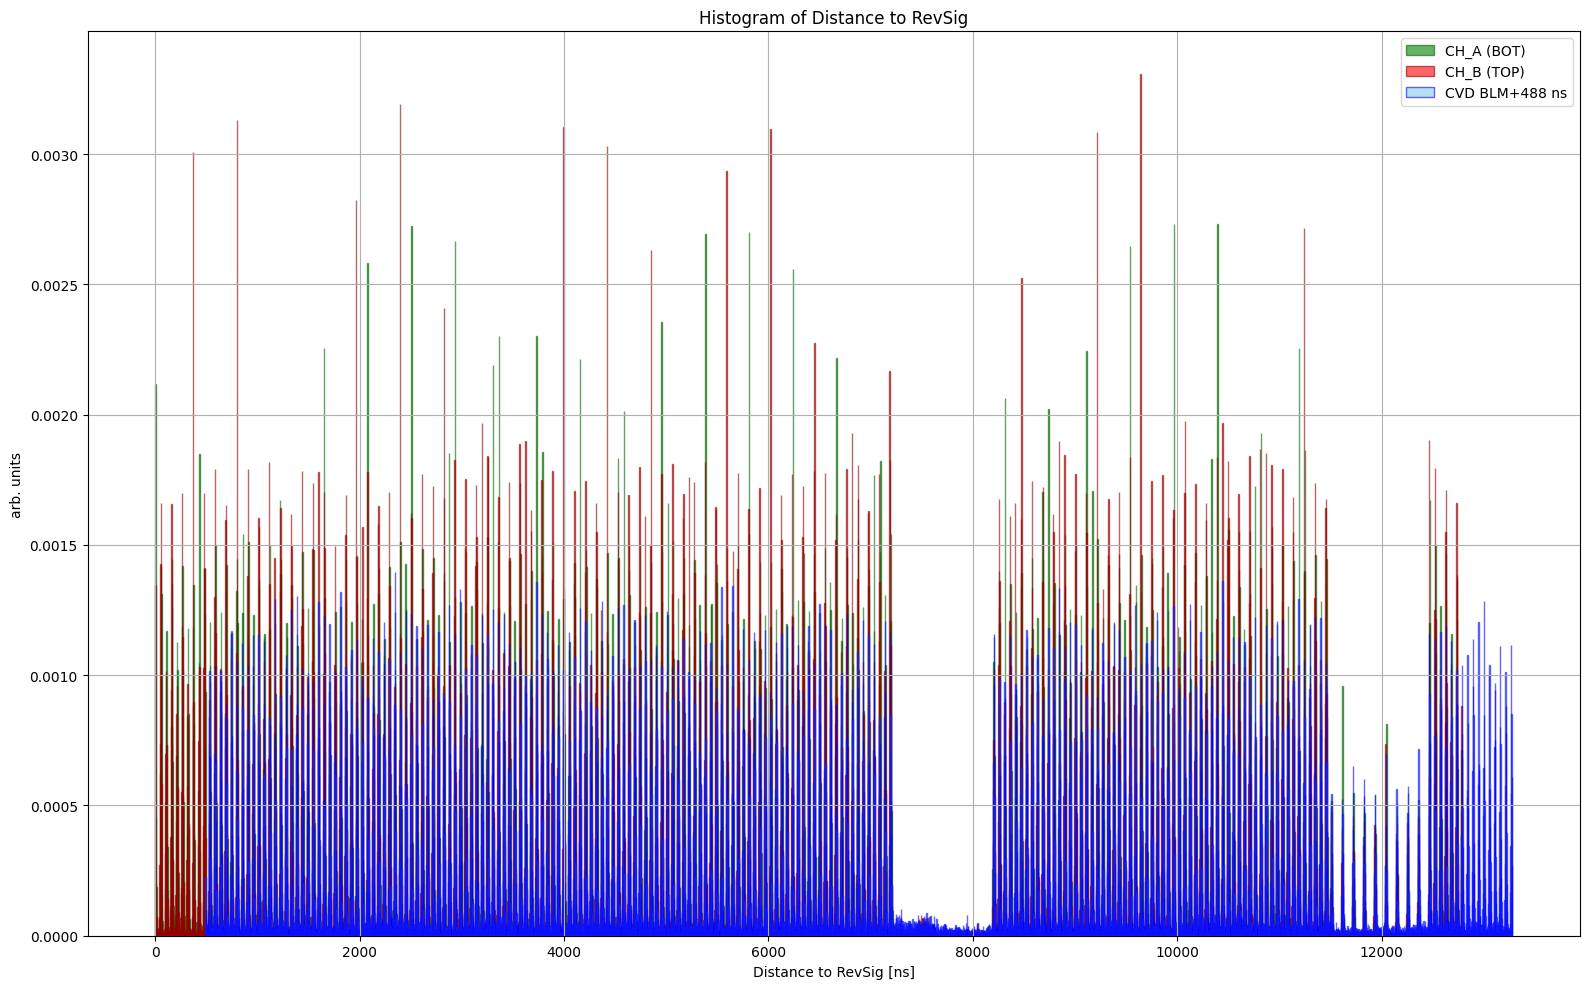

In [357]:
# Plot histogram
fig, ax = plt.subplots(figsize=(16, 10))
# Desired total count
N = 1

timing_CLAWS_a = (-1) * df_a['dist_to_revsig'] * dtime_ns
timing_CLAWS_b = (-1) * df_b['dist_to_revsig'] * dtime_ns
# Scale weights so total area = N
weights = np.ones_like(all_distances_1) * N / len(all_distances_1)
weights_a = np.ones_like((-1) * df_a['dist_to_revsig'] * dtime_ns) * N / len(df_a['dist_to_revsig'])
weights_b = np.ones_like((-1) * df_b['dist_to_revsig'] * dtime_ns) * N / len(df_b['dist_to_revsig'])

# Plot histogram as usual
#ax.hist(all_distances_2, bins=4000, color='red', edgecolor=blm_col[2], label=ch_label[2], alpha=0.6)
#ax.hist(all_distances_3, bins=4000, color='green', edgecolor=blm_col[3], label=ch_label[3], alpha=0.6)
plt.hist(timing_CLAWS_a, bins=3000, color='green', edgecolor=blm_col[3],    label='CH_A (BOT)', alpha=0.6, weights=weights_a)
plt.hist(timing_CLAWS_b, bins=3000, color='red'    , edgecolor='darkred', label='CH_B (TOP)', alpha=0.6, weights=weights_b)
ax.hist(all_distances_1+488, bins=4000, color='skyblue', edgecolor=blm_col[1], label=ch_label[1]+"+488 ns", alpha=0.6, weights=weights)

#ax.set_xlim(11500, 11900)
#ax.set_ylim(0,1e-3)
#ax.set_ylim(0, 1050)
#ax.set_ylim(0, 2)

ax.set_xlabel('Distance to RevSig [ns]')
ax.set_ylabel('arb. units')
ax.set_title('Histogram of Distance to RevSig')
# Add the green box
#rect = patches.Rectangle((9000, 0), 1000, ax.get_ylim()[1], linewidth=0, facecolor='green', alpha=0.3)
#ax.add_patch(rect)

# Add the label inside the green box
#ax.text(9050, ax.get_ylim()[1]*0.9, 'B: Blue and Yellow Beams\n(9–10 µs)',
#        fontsize=local_fontsize, color='black', backgroundcolor='lightgreen')

ax.grid(True)
ax.legend()

plt.tight_layout()
plt.savefig(f"./Plots/revsig_{date_string}_B.png", dpi=300)

plt.show()

Fit parameters: 0.0005040074444844425 11614.686865821775 5.219004882744697
Fit parameters CH_A: 0.0004531410499939293 11611.93209370741 5.3921560611295005


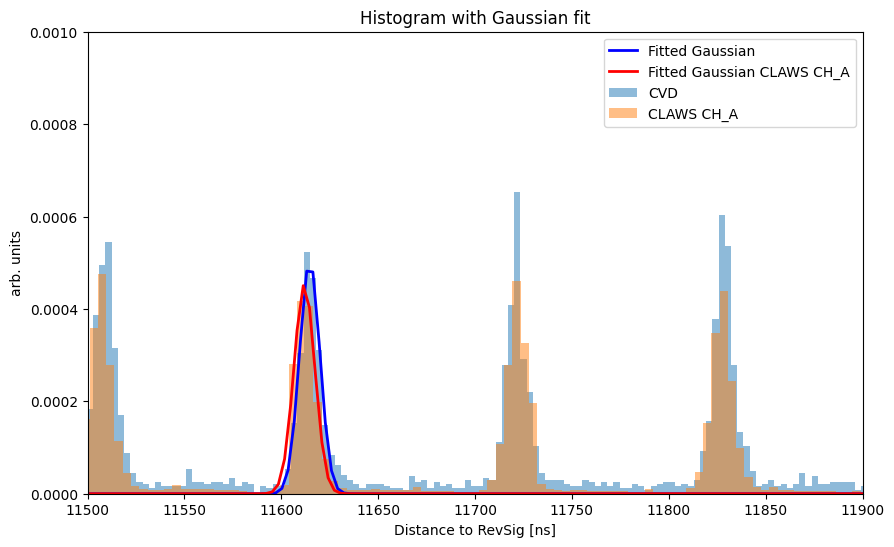

In [558]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

fit_data_1 = timing_CLAWS_b
fit_data = all_distances_1+488

# --- Define Gaussian ---
def gaussian(x, amp, mean, sigma):
    return amp * np.exp(-(x - mean) ** 2 / (2 * sigma ** 2))



# --- Make histogram ---
counts_int, bin_edges = np.histogram(fit_data, bins=4000)
counts_int_1, bin_edges_1 = np.histogram(fit_data_1, bins=3000)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
bin_centers_1 = (bin_edges_1[:-1] + bin_edges_1[1:]) / 2



counts = counts_int/sum(counts_int)
counts_1 = counts_int_1/sum(counts_int_1)

# --- Select region to fit (example: between 40 and 60) ---
region = (bin_centers > 11590) & (bin_centers < 11650)
x_fit = bin_centers[region]
y_fit = counts[region]

region_1 = (bin_centers_1 > 11550) & (bin_centers_1 < 11650)
x_fit_1 = bin_centers_1[region_1]
y_fit_1 = counts_1[region_1]

# --- Fit Gaussian ---
popt, pcov = curve_fit(gaussian, x_fit, y_fit, p0=[max(y_fit), np.mean(x_fit), 5])
amp, mean, sigma = popt
print("Fit parameters:", amp, mean, sigma)

popt_1, pcov_1 = curve_fit(gaussian, x_fit_1, y_fit_1, p0=[sum(y_fit_1), x_fit_1[np.argmax(y_fit_1)], 10])
amp_1, mean_1, sigma_1 = popt_1
print("Fit parameters CH_A:", amp_1, mean_1, sigma_1)

# --- Plot histogram and fitted Gaussian ---
x_dense = np.linspace(min(bin_centers), max(bin_centers), 4000)
x_dense_1 = np.linspace(min(bin_centers_1), max(bin_centers_1), 4000)
fit_curve = gaussian(x_dense, amp, mean, sigma)
fit_curve_1 = gaussian(x_dense_1, amp_1, mean_1, sigma_1)

plt.figure(figsize=(10,6))
plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.5, label="CVD")
plt.bar(bin_centers_1, counts_1, width=bin_edges_1[1]-bin_edges_1[0], alpha=0.5, label="CLAWS CH_A")
plt.plot(x_dense, fit_curve, 'b-', lw=2, label="Fitted Gaussian")
plt.plot(x_dense_1, fit_curve_1, 'r-', lw=2, label="Fitted Gaussian CLAWS CH_A")
plt.xlim(11500, 11900)
#plt.xlim(10000, 11900)
plt.ylim(0,1e-3)
plt.legend()
#plt.yscale("log")   # <-- log scale for y-axis

plt.ylabel('arb. units')
plt.xlabel('Distance to RevSig [ns]')
plt.title("Histogram with Gaussian fit")
plt.show()





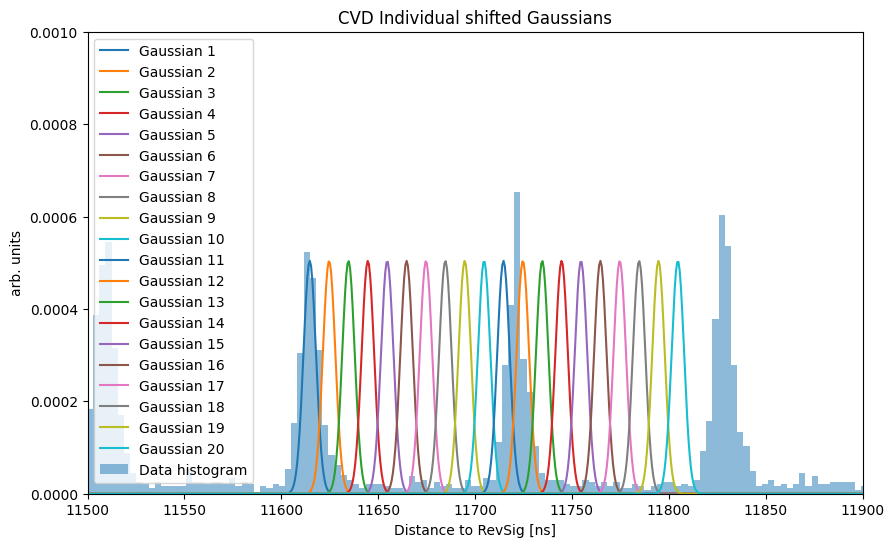

In [559]:
# --- Generate shifted Gaussians ---
n = 20
spacing = 10   # change this for different spacing
x_dense = np.linspace(min(bin_centers), max(bin_centers) + spacing*n, 4000*5)
x_dense_1 = np.linspace(min(bin_centers_1), max(bin_centers_1) + spacing*n, 4000*5)
gaussians = []
gaussians_1 = []

for i in range(n):
    shift = i * spacing
    g = gaussian(x_dense, amp, mean + shift, sigma-2)
    gaussians.append(g)
    g_1 = gaussian(x_dense_1, amp_1, mean_1 + shift, sigma_1-2)
    gaussians_1.append(g_1)

# --- Plot individual Gaussians ---
plt.figure(figsize=(10,6))
for i, g in enumerate(gaussians):
    plt.plot(x_dense, g, label=f"Gaussian {i+1}")

plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.5, label="Data histogram")

plt.legend()
plt.ylim(0,1e-3)
plt.xlim(11500, 11900)
plt.ylabel('arb. units')
plt.xlabel('Distance to RevSig [ns]')

plt.title("CVD Individual shifted Gaussians")
plt.show()


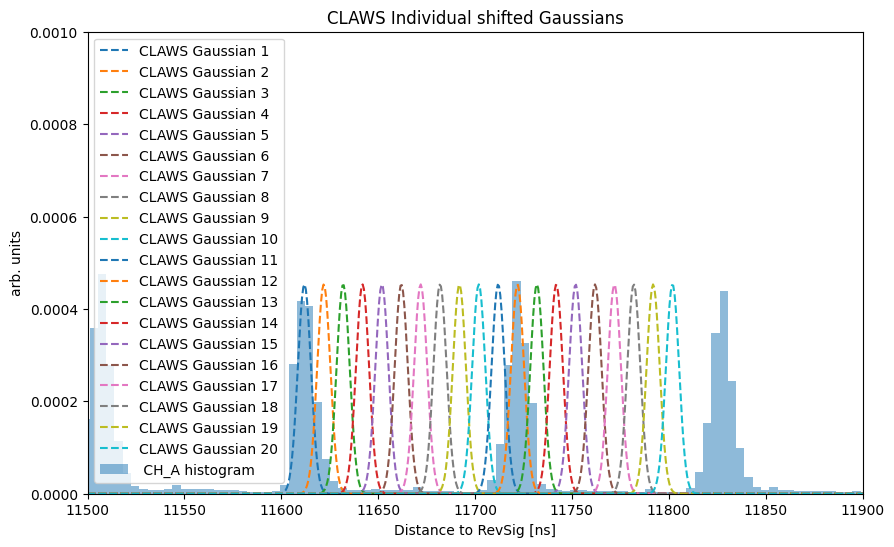

In [560]:


# --- Plot individual Gaussians ---
plt.figure(figsize=(10,6))

for i, g_1 in enumerate(gaussians_1):
    plt.plot(x_dense_1, g_1, '--', label=f"CLAWS Gaussian {i+1}")
plt.bar(bin_centers_1, counts_1, width=bin_edges_1[1]-bin_edges_1[0], alpha=0.5, label=" CH_A histogram")

plt.legend()
plt.ylim(0,1e-3)
plt.xlim(11500, 11900)
plt.ylabel('arb. units')
plt.xlabel('Distance to RevSig [ns]')

plt.title("CLAWS Individual shifted Gaussians")
plt.show()


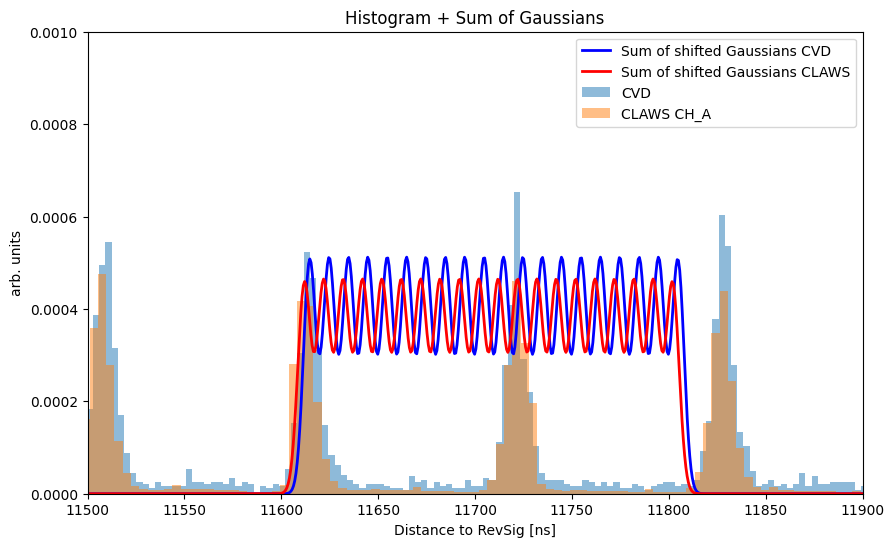

In [570]:
# --- Add them up ---
sum_gaussians = np.sum(gaussians, axis=0)
sum_gaussians_1 = np.sum(gaussians_1, axis=0)

plt.figure(figsize=(10,6))
plt.bar(bin_centers, counts, width=bin_edges[1]-bin_edges[0], alpha=0.5, label="CVD")
plt.bar(bin_centers_1, counts_1, width=bin_edges_1[1]-bin_edges_1[0], alpha=0.5, label="CLAWS CH_A")
plt.plot(x_dense, sum_gaussians, color='blue', lw=2, label="Sum of shifted Gaussians CVD")
plt.plot(x_dense_1, sum_gaussians_1, color='red', lw=2, label="Sum of shifted Gaussians CLAWS")
plt.legend()
plt.xlim(11500, 11900)
plt.ylim(0,1e-3)

plt.title("Histogram + Sum of Gaussians")
plt.ylabel('arb. units')
plt.xlabel('Distance to RevSig [ns]')

plt.show()

In [562]:
df_a.head()

,peak_indicies,peak_heights,peak_heights_above_mean,widths,dist_to_revsig,integrals
0,69947933,-25410.0,672.074976,42.003891,-1252,3013641.5
1,74817464,-25410.0,672.074976,26.003891,-2888,3000921.0
2,14636092,-25410.0,712.314044,42.003891,-272,3041267.0
3,58861727,-25410.0,653.434312,42.003891,-355,3044992.5
4,20421688,-25153.0,837.959274,9.996109,-2233,3071844.0


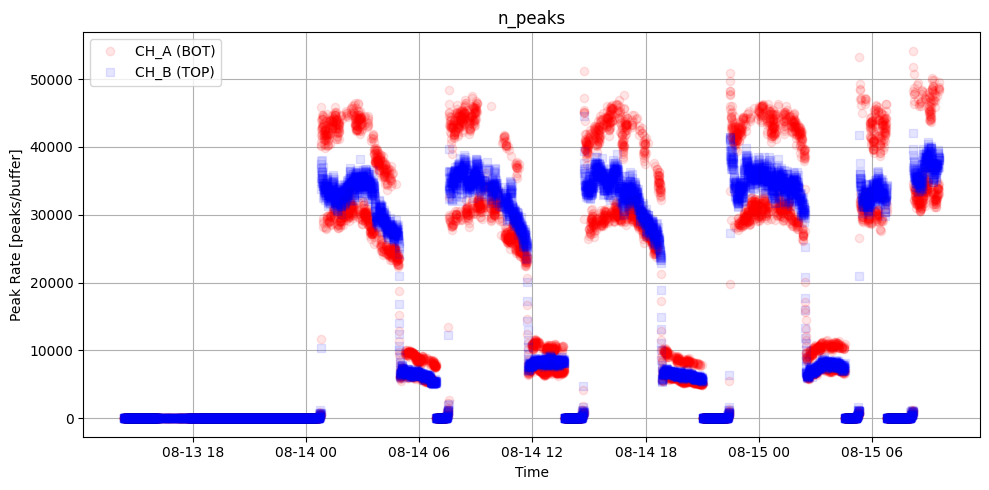

In [563]:
plt.figure(8,figsize=(10, 5))
plt.plot(timestamps_a, np.array(n_peaks_a)/(buffer_size * dtime_ns * 1e-9), marker='o', linestyle='', color='red', alpha=0.1, label='CH_A (BOT)')
plt.plot(timestamps_b, np.array(n_peaks_b)/(buffer_size * dtime_ns * 1e-9), marker='s', linestyle='', color='blue', alpha=0.1, label='CH_B (TOP)')

plt.xlabel("Time")
plt.ylabel("Peak Rate [peaks/buffer]")
plt.title("n_peaks")
plt.grid(True)
plt.tight_layout()
plt.legend()
#plt.yscale('log')
plt.savefig("fig_8.png")
plt.show()

In [564]:
# Prepare both DataFrames

timestamps_a = pd.to_datetime(timestamps_a)
timestamps_b = pd.to_datetime(timestamps_b)

rate_a = np.array(n_peaks_a) / (buffer_size * dtime_ns * 1e-9)
rate_b = np.array(n_peaks_b) / (buffer_size * dtime_ns * 1e-9)

df_rate_a = pd.DataFrame({'timestamp': timestamps_a, 'rate_per_sec_a': rate_a})
df_rate_b = pd.DataFrame({'timestamp': timestamps_b, 'rate_per_sec_b': rate_b})

print(df_ch.head())
print(df_rate_a.head())

             timestamp  ch  count  avg_peak_height  rate_per_min  rate_per_sec
3  2025-07-18 15:24:00   3    180         0.002659     60.000000      1.000000
6  2025-07-18 15:30:00   3    177         0.002771     59.000000      0.983333
9  2025-07-18 15:36:00   3    177         0.002809     59.000000      0.983333
12 2025-07-18 15:42:00   3    185         0.002649     61.666667      1.027778
15 2025-07-18 15:48:00   3    183         0.002782     61.000000      1.016667
                   timestamp  rate_per_sec_a
0 2025-08-13 14:20:47.159091             0.0
1 2025-08-13 14:21:03.925132             0.0
2 2025-08-13 14:21:15.969489             0.0
3 2025-08-13 14:21:27.270206             0.0
4 2025-08-13 14:21:38.887762             0.0


In [ ]:

# Ensure timestamp is datetime
df_rate_a["timestamp"] = pd.to_datetime(df_rate_a["timestamp"])
#combined["timestamp"] = pd.to_datetime(combined["timestamp"])
print(combined["timestamp"].dtype)
print(combined[mask_combined].head())
#select = ()
df_ch1 = combined[mask_combined][(combined['ch'] == 1) & (combined['avg_peak_height'] > 0.085) & (combined['rate_per_sec'] > 0)]
df_ch2 = combined[mask_combined][(combined['ch'] == 2) & (combined['avg_peak_height'] > 0.001) & (combined['rate_per_sec'] > 1)]
df_ch3 = combined[mask_combined][(combined['ch'] == 3) & (combined['avg_peak_height'] > 0.00225) & (combined['rate_per_sec'] > 1)]



#df_ch1['timestamp'] = pd.to_datetime(df_ch1['timestamp'])
#df_ch2['timestamp'] = pd.to_datetime(df_ch2['timestamp'])
#df_ch3['timestamp'] = pd.to_datetime(df_ch3['timestamp'])

# Sort both by time (merge_asof requires sorted input)
df_rate_a = df_rate_a.sort_values("timestamp")
df_ch1 = df_ch1.sort_values("timestamp")
df_ch2 = df_ch2.sort_values("timestamp")
df_ch3 = df_ch3.sort_values("timestamp")

matching_tolerance = pd.Timedelta("10min")
    
print(df_ch1.head())
# Merge df2 onto df1 (find nearest timestamp within a tolerance)
df_merged1 = pd.merge_asof(
    df_ch1,
    df_rate_a,
    on="timestamp",
    direction="nearest",
    tolerance=matching_tolerance  # allow up to 1 minute offset
)
df_merged2 = pd.merge_asof(
    df_ch2,
    df_rate_a,
    on="timestamp",
    direction="nearest",
    tolerance=matching_tolerance  # allow up to 1 minute offset
)
df_merged3 = pd.merge_asof(
    df_ch3,
    df_rate_a,
    on="timestamp",
    direction="nearest",
    tolerance=matching_tolerance  # allow up to 1 minute offset
)

# Drop rows with no match
df_merged1 = df_merged1.dropna()
df_merged2 = df_merged2.dropna()
df_merged3 = df_merged3.dropna()

print(df_merged1.head())


datetime64[ns]
            timestamp  ch  count  avg_peak_height  rate_per_min  rate_per_sec
0 2025-07-18 15:18:00   1     22         0.204639          11.0      0.183333
1 2025-07-18 15:24:00   1     54         0.201189          27.0      0.450000
2 2025-07-18 15:24:00   2    206         0.001378         103.0      1.716667
3 2025-07-18 15:24:00   3    120         0.002960          60.0      1.000000
4 2025-07-18 15:30:00   1     35         0.201646          17.5      0.291667
             timestamp  ch  count  avg_peak_height  rate_per_min  rate_per_sec
0  2025-07-18 15:18:00   1     22         0.204639          11.0      0.183333
1  2025-07-18 15:24:00   1     54         0.201189          27.0      0.450000
4  2025-07-18 15:30:00   1     35         0.201646          17.5      0.291667
7  2025-07-18 15:36:00   1     58         0.167305          29.0      0.483333
10 2025-07-18 15:42:00   1     43         0.193894          21.5      0.358333
                      timestamp  rate_per_s

/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_35427/1088721087.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(combined[mask_combined].head())
/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_35427/1088721087.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_ch1 = combined[mask_combined][(combined['ch'] == 1) & (combined['avg_peak_height'] > 0.085) & (combined['rate_per_sec'] > 0)]
/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_35427/1088721087.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_ch1 = combined[mask_combined][(combined['ch'] == 1) & (combined['avg_peak_height'] > 0.085) & (combined['rate_per_sec'] > 0)]
/var/folders/6m/3j6qvgsd3lxgmv5gsl7n4sbm0000gp/T/ipykernel_35427/1088721087.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_ch2 = combined[mask_combined][(combined['ch'] == 2) & (combin

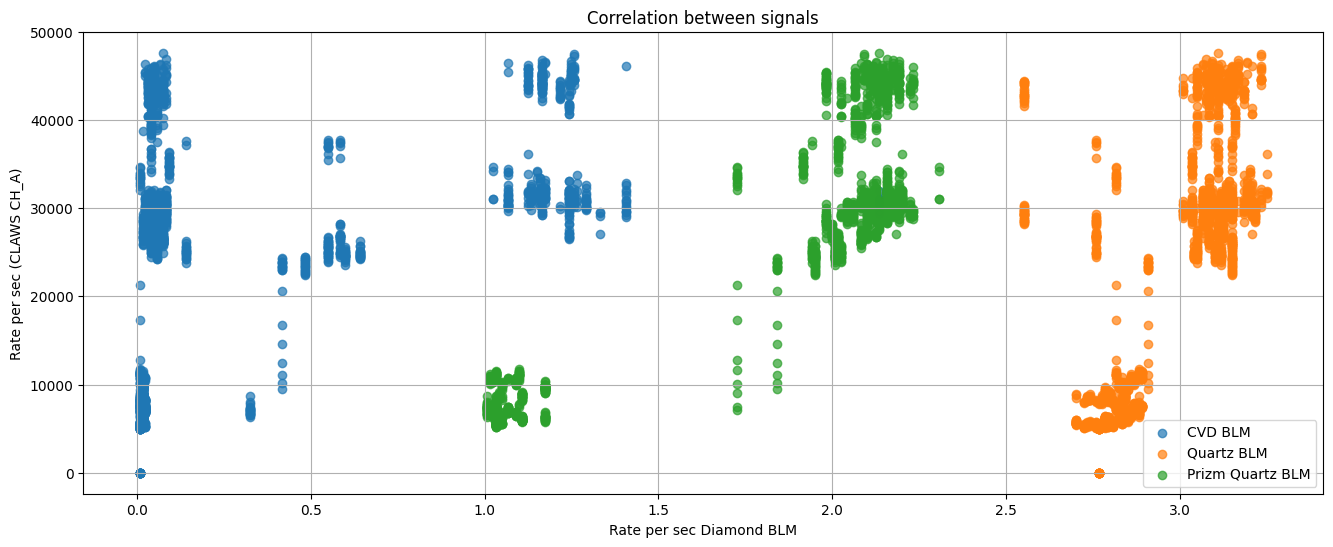

In [572]:

plt.figure(figsize=(16,6))
plt.scatter(df_merged1["rate_per_sec"], df_merged1["rate_per_sec_a"], label=ch_label[1], alpha=0.7)
plt.scatter(df_merged2["rate_per_sec"], df_merged2["rate_per_sec_a"], label=ch_label[2], alpha=0.7)
plt.scatter(df_merged3["rate_per_sec"], df_merged3["rate_per_sec_a"], label=ch_label[3], alpha=0.7)
plt.ylabel("Rate per sec (CLAWS CH_A)")
plt.xlabel("Rate per sec Diamond BLM")
plt.title("Correlation between signals")
plt.grid(True)
#plt.xlim(0, 0.5)
plt.legend()

#plt.xscale('log')
#plt.yscale('log')
plt.show()


In [567]:
import numpy as np
import pandas as pd

# Load the npz file
data1 = np.load("./WF_data/waveform_00103_CH1.npz")
data2 = np.load("./WF_data/waveform_00111_CH2.npz")
data3 = np.load("./WF_data/waveform_00111_CH3.npz")

# Inspect available arrays
print(data1.files)   # lists all keys stored in the npz
print(data2.files)   # lists all keys stored in the npz
print(data3.files)   # lists all keys stored in the npz

for key in data1.files:
    print(key, data1[key].shape)
    
def npz_to_df(data):
    out = {}
    for key in data.files:
        arr = data[key]

        if arr.ndim == 1:  # waveform
            out[key] = [arr]   # keep entire waveform in a single row

        elif arr.ndim == 2:  # e.g. peaks
            # store as nested arrays (list of rows)
            out[key] = [arr]

        elif arr.ndim == 0:  # scalar metadata
            out[key] = [arr.item()]

        else:
            out[key] = [arr]

    return pd.DataFrame(out)

df_wf1 = npz_to_df(data1)
df_wf2 = npz_to_df(data2)
df_wf3 = npz_to_df(data3)


print(df_wf1.head())
print(df_wf2.head())
print(df_wf3.head())

['peaks', 'ch1', 'ch2', 'timestamp', 'sample_rate', 'buffer_size', 'trigger_chn', 'trigger_level']
['peaks', 'ch1', 'ch2', 'timestamp', 'sample_rate', 'buffer_size', 'trigger_chn', 'trigger_level']
['peaks', 'ch1', 'ch2', 'timestamp', 'sample_rate', 'buffer_size', 'trigger_chn', 'trigger_level']
peaks (2, 5)
ch1 (1000000,)
ch2 (1000000,)
timestamp ()
sample_rate ()
buffer_size ()
trigger_chn ()
trigger_level ()
                                               peaks  \
0  [[500001.0, 0.11934156378600824, 2.875, -16201...   

                                                 ch1  \
0  [0.0, 0.0, 0.0, 0.0411522633744856, 0.0, 0.0, ...   

                                                 ch2  \
0  [-0.00411522633744856, 0.0, 0.0, -0.0041152263...   

                    timestamp   sample_rate  buffer_size  trigger_chn  \
0  2025-07-24T23:04:51.912209  1.500000e+09      1000000            1   

   trigger_level  
0           0.04  
                                               peaks  \
0  [[

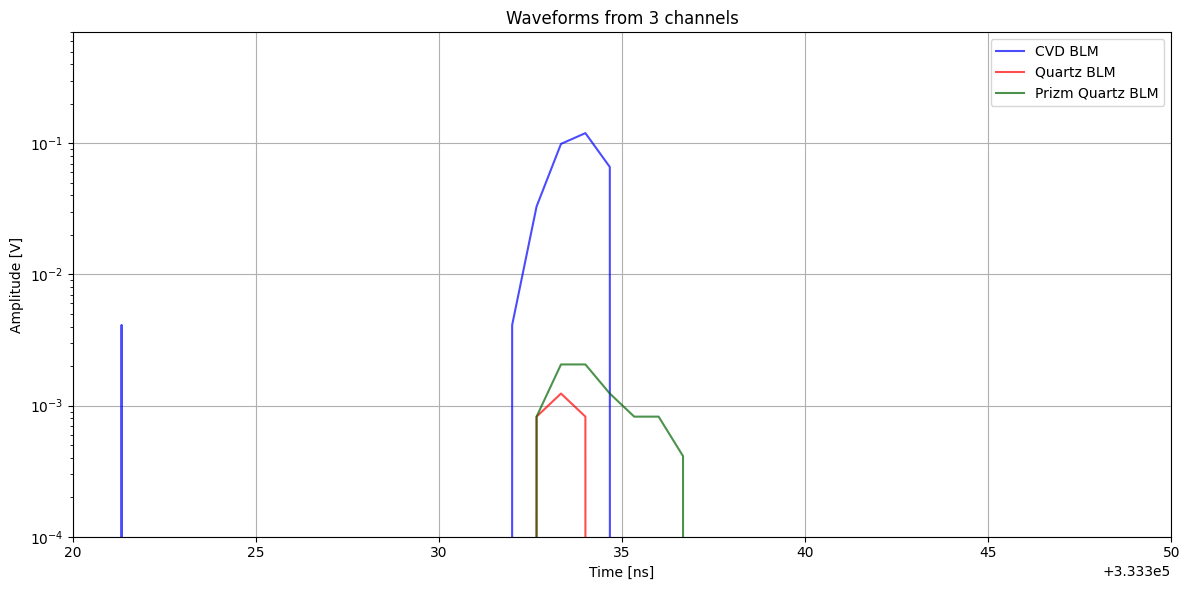

In [568]:
# Extract ch1 and ch2 arrays
ch1 = df_wf1["ch2"].iloc[0]   # waveform as numpy array
ch2 = df_wf2["ch2"].iloc[0]
ch3 = df_wf3["ch2"].iloc[0]
wf_channels = [ch1, ch2, ch3]
# Sampling parameters
dt = 1 / (2*750e6)   # seconds per sample
t1 = np.arange(len(ch1)) * dt  # time axis for ch1
t2 = np.arange(len(ch2)) * dt # time axis for ch2
t3 = np.arange(len(ch2)) * dt # time axis for ch2

times = [t1, t2, t3]
# Plot
plt.figure(figsize=(12,6))
#plt.plot(t*1e9, ch1, label="CH1")  # convert time to ns
plt.plot(t1*1e9, ch1, color=blm_col[1], label=ch_label[1], alpha=0.7)
plt.plot(t2*1e9, ch2, color=blm_col[2], label=ch_label[2], alpha=0.7)
plt.plot(t3*1e9, ch3, color=blm_col[3], label=ch_label[3], alpha=0.7)

plt.xlim(0.66664*1e6/2, 0.6667*1e6/2)
plt.ylim(1e-4, 0.7)
plt.yscale('log')
plt.xlabel("Time [ns]")
plt.ylabel("Amplitude [V]")
plt.title("Waveforms from 3 channels")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



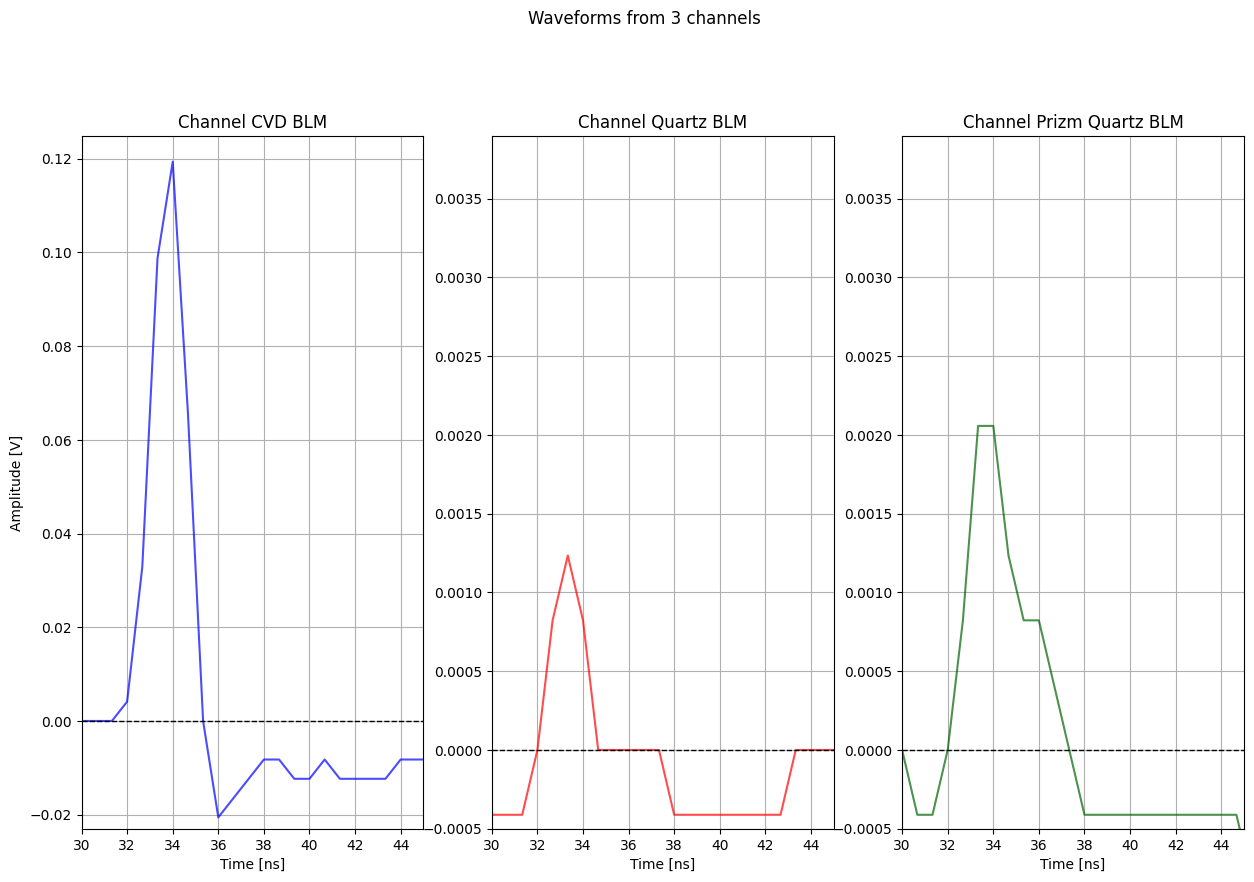

In [569]:
# Plotting the rate per second for each channel
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 9))
ylim = [0.1249, 0.0039, 0.0039]  # Set x-axis limits for each channel
ylim_min = [-0.023, -0.0005, -0.0005]  # Set x-axis limits for each channel
offset = 0.6666e6/2
x_min = offset+60/2
x_max = offset+90/2
for i, ch in enumerate(wf_channels):

    
    axs[i].plot(times[i]*1e9-offset, ch, color=blm_col[i+1], label=ch_label[i+1], alpha=0.7)
    # Draw dashed line at y=0
    axs[i].axhline(y=0, color='black', linestyle='--', linewidth=1)


    axs[i].set_xlabel('Time [ns]')    
    axs[i].set_title(f'Channel {ch_label[i+1]}')
    #axs[i].set_xscale('log')
    axs[i].set_xlim(x_min-offset, x_max-offset)
    axs[i].set_ylim(ylim_min[i], ylim[i])  # Set x-axis limit to 0-1000 mV
    axs[i].grid(True)
    #axs[i].legend()

axs[0].set_ylabel('Amplitude [V]')
# Draw vertical line at 80 mV on the first axis (axs[0])
#axs[0].axvline(x=80, color='black', linestyle='--', linewidth=1, label='Threshold 80 mV')
#axs[0].legend()
#axs[1].legend()
#axs[2].legend()

# Draw vertical line at 2.25 on the last axis (axs[-1])
#axs[-1].axvline(x=2.25, color='black', linestyle='--', linewidth=1, label='Threshold 2.25 mV')
#axs[-1].legend()

plt.suptitle('Waveforms from 3 channels', y=1.02)
#plt.tight_layout()
plt.savefig(f"./Plots/peaks_by_channel.png", dpi=300)
plt.show()